Basic dataset EDA + product review context EDA.  
Reference: https://www.kaggle.com/code/harshsingh2209/complete-guide-to-eda-on-text-data

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pandas as pd
import numpy as np
import string
import re
import nltk

from tqdm import trange
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

file_path = '/content/amazon_user_reviews.parquet'

df = pd.read_parquet(file_path)

In [6]:
df.head()

,category,rating,sentiment,tokens,text_cleaned,original_text,token_count,title,images,verified_purchase,asin,parent_asin,user_id,datetime,helpful_vote
0,Appliances,5.0,positive,"[exelent, save, coffee, water, waste, easy, cl...",exelent save coffee water waste easy clean act...,"Exelent, save on coffee, water, no waste, e...",14,savings,[],True,B00LGEKOMS,B07RNJY499,AEOVCZC77QZJQPBIAIKCFV7AS7PA,2017-10-16 22:46:40.529,0
1,Appliances,5.0,positive,"[ordered, wrong, part, quality, part, seemed, ...",ordered wrong part quality part seemed good,Ordered wrong part but the quality of this par...,7,check part numbers,[],True,B094YWPF68,B094YWPF68,AEU2V36H3G45EFVLASUPD56B7ATQ,2021-08-30 19:50:53.564,0
2,Appliances,5.0,positive,[described],described,as described,1,five stars,[],True,B00LQL043A,B00LQL043A,AE7FJMYY4AKWBDASLTMMQ5WASB7A,2016-09-28 15:08:18.000,0
3,Appliances,5.0,positive,"[used, replace, broken, door, bin, back, ice, ...",used replace broken door bin back ice dispense...,Used to replace a broken door bin on the back ...,18,fits,[],True,B00C29G3N0,B00C29G3N0,AGM4WN3EOAA3RUAUXGH2S2AUL6WA,2019-01-06 21:01:13.614,3
4,Appliances,5.0,positive,"[husband, us, broke, cleaning, replace, well, ...",husband us broke cleaning replace well say one...,My husband uses these. I broke it when cleanin...,35,easy peasy to use and clean.,[],True,B01DP1IWKU,B092LLM7H3,AEBXJRP4COCKP22LPKUDVCQ7JKVQ,2019-08-09 02:13:50.975,0


# Textual Content Analysis
- punctuation count
- words count
- heatmap

In [19]:
# Basic length features
df['char_count'] = df['original_text'].str.len()
df['word_count'] = df['original_text'].str.split().str.len()
df['avg_word_length'] = df['char_count'] / df['word_count']

In [20]:
# Punctuation
df['exclamation_count'] = df['original_text'].str.count('!')
df['question_count'] = df['original_text'].str.count('\?')
df['period_count'] = df['original_text'].str.count('\.')
df['comma_count'] = df['original_text'].str.count(',')
df['ellipsis_count'] = df['original_text'].str.count('\.\.\.')
df['total_punctuation'] = (df['exclamation_count'] + df['question_count'] +
                            df['period_count'] + df['comma_count'])

<>:3: SyntaxWarning: invalid escape sequence '\?'
<>:4: SyntaxWarning: invalid escape sequence '\.'
<>:6: SyntaxWarning: invalid escape sequence '\.'
<>:3: SyntaxWarning: invalid escape sequence '\?'
<>:4: SyntaxWarning: invalid escape sequence '\.'
<>:6: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipython-input-1397081852.py:3: SyntaxWarning: invalid escape sequence '\?'
  df['question_count'] = df['original_text'].str.count('\?')
/tmp/ipython-input-1397081852.py:4: SyntaxWarning: invalid escape sequence '\.'
  df['period_count'] = df['original_text'].str.count('\.')
/tmp/ipython-input-1397081852.py:6: SyntaxWarning: invalid escape sequence '\.'
  df['ellipsis_count'] = df['original_text'].str.count('\.\.\.')


In [21]:
# Capitalization features
df['all_caps_words'] = df['original_text'].str.findall(r'\b[A-Z]{2,}\b').str.len()
df['uppercase_count'] = df['original_text'].str.findall(r'[A-Z]').str.len()
df['uppercase_ratio'] = df['uppercase_count'] / df['char_count']

# Binary indicators
df['has_exclamation'] = (df['exclamation_count'] > 0).astype(int)
df['has_question'] = (df['question_count'] > 0).astype(int)
df['has_all_caps'] = (df['all_caps_words'] > 0).astype(int)

In [22]:
# Group by rating and calculate statistics
text_features = ['exclamation_count', 'question_count', 'word_count',
                 'char_count', 'all_caps_words', 'uppercase_ratio',
                 'total_punctuation', 'avg_word_length']

analysis_by_rating = df.groupby('rating')[text_features].agg(['mean', 'median', 'std'])
print("\n", analysis_by_rating.round(2))


        exclamation_count              question_count              word_count  \
                    mean median   std           mean median   std       mean   
rating                                                                         
1.0                 0.56    0.0  1.60           0.10    0.0  0.46      51.11   
2.0                 0.31    0.0  1.07           0.07    0.0  0.35      67.94   
3.0                 0.28    0.0  1.31           0.07    0.0  0.34      87.30   
4.0                 0.35    0.0  1.53           0.07    0.0  0.40      90.74   
5.0                 0.59    0.0  1.56           0.04    0.0  0.31      56.93   

                      char_count  ... all_caps_words uppercase_ratio         \
       median     std       mean  ...            std            mean median   
rating                            ...                                         
1.0      27.0   78.26     275.55  ...           5.55            0.04   0.03   
2.0      36.0   87.39     367.61  ...    

In [23]:
print("CORRELATION WITH RATING")

# Calculate correlation of each feature with rating
correlations = df[text_features + ['rating']].corr()['rating'].sort_values(ascending=False)
print("\n", correlations)


CORRELATION WITH RATING

 rating               1.000000
avg_word_length      0.044129
exclamation_count    0.040752
uppercase_ratio      0.004856
all_caps_words      -0.024566
char_count          -0.035824
word_count          -0.039700
total_punctuation   -0.043211
question_count      -0.047880
Name: rating, dtype: float64


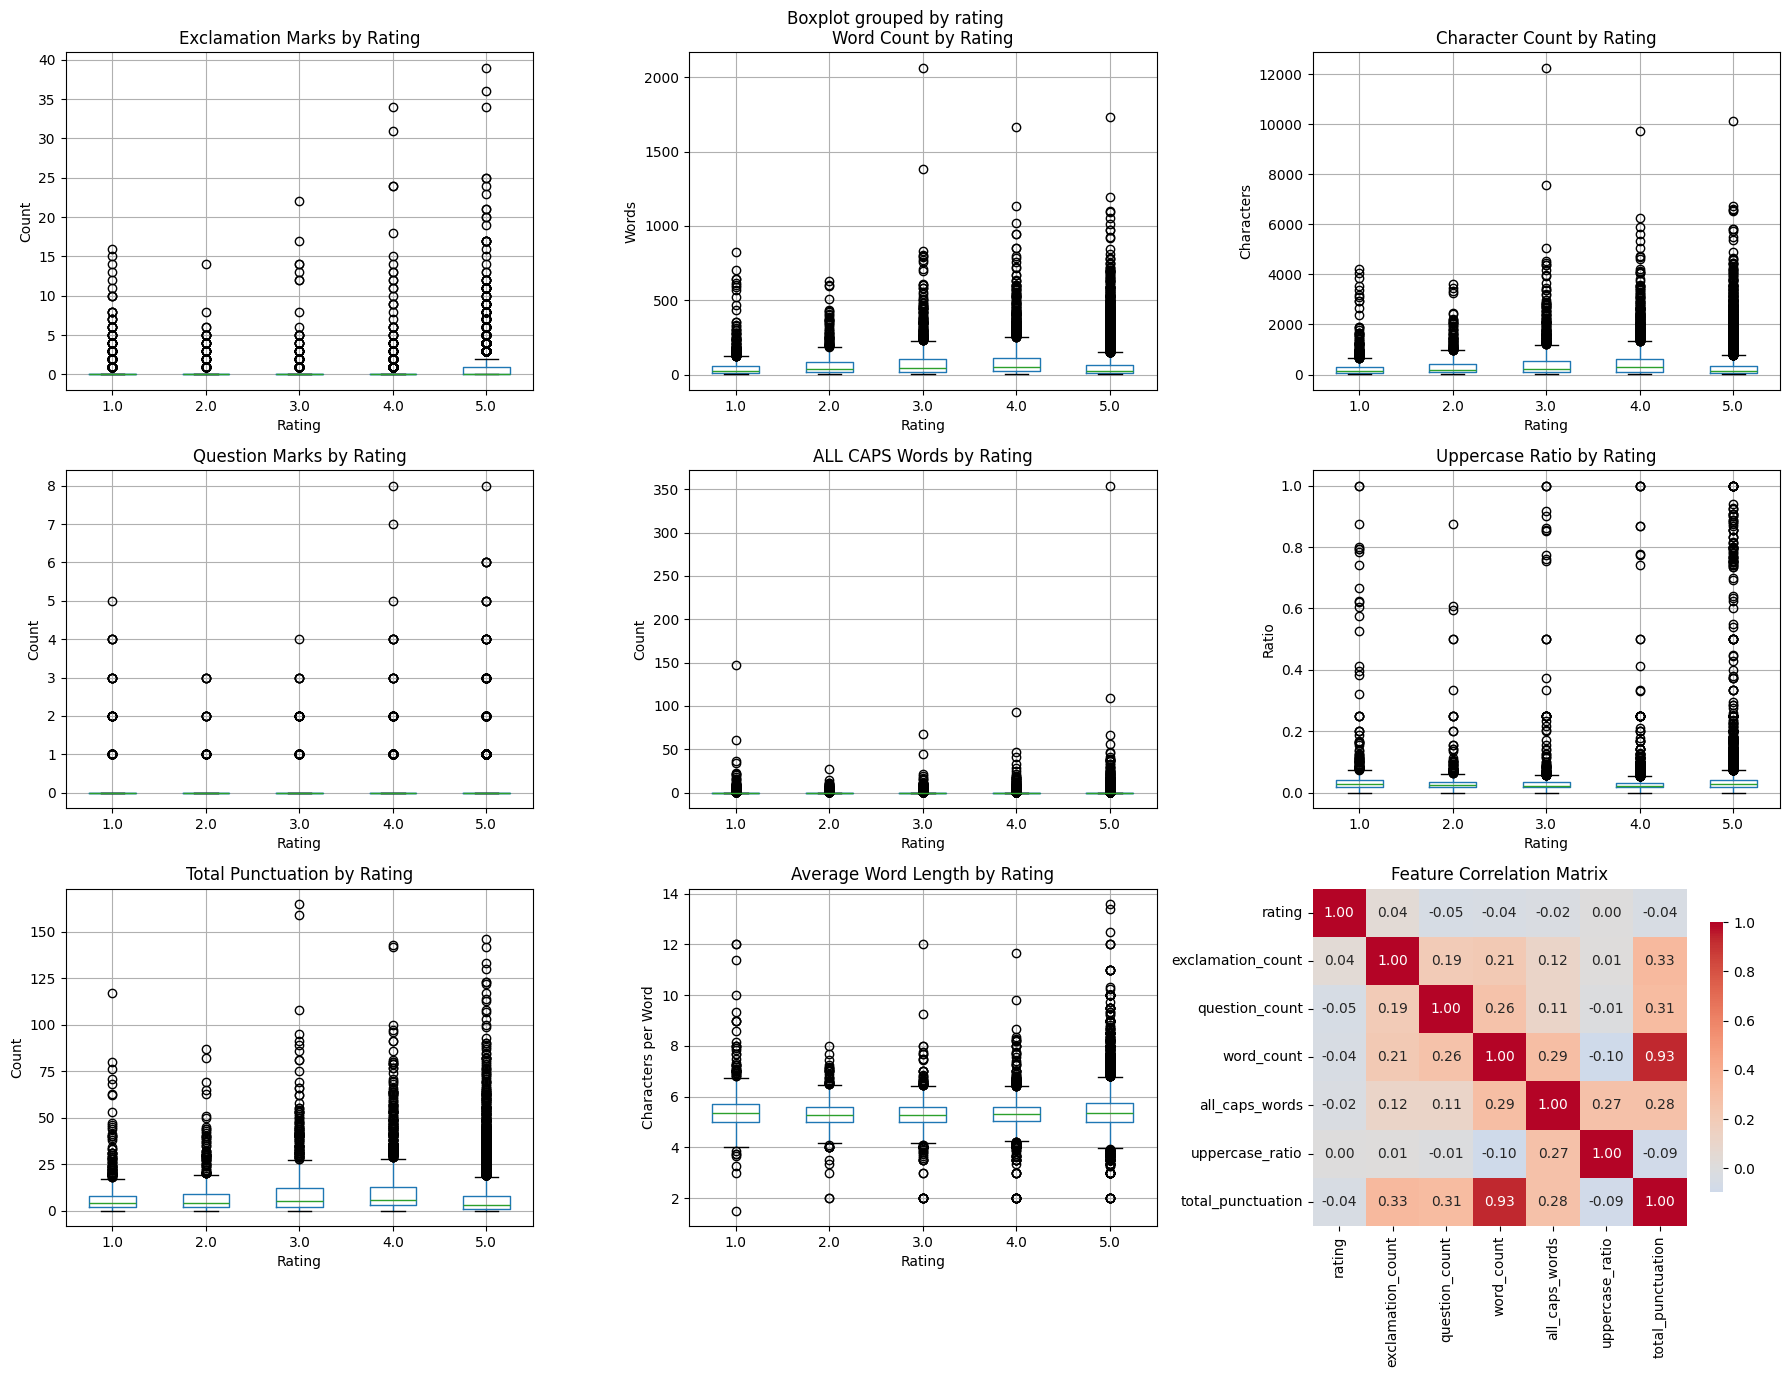

In [39]:
# PART 4: VISUALIZATIONS

fig, axes = plt.subplots(3, 3, figsize=(18, 14))
fig.suptitle('Textual Content Analysis by Rating', fontsize=16, fontweight='bold')

# 1. Exclamation marks
df.boxplot(column='exclamation_count', by='rating', ax=axes[0, 0])
axes[0, 0].set_title('Exclamation Marks by Rating')
axes[0, 0].set_xlabel('Rating')
axes[0, 0].set_ylabel('Count')
plt.sca(axes[0, 0])
plt.xticks(rotation=0)

# 2. Word count
df.boxplot(column='word_count', by='rating', ax=axes[0, 1])
axes[0, 1].set_title('Word Count by Rating')
axes[0, 1].set_xlabel('Rating')
axes[0, 1].set_ylabel('Words')
plt.sca(axes[0, 1])
plt.xticks(rotation=0)

# 3. Character count
df.boxplot(column='char_count', by='rating', ax=axes[0, 2])
axes[0, 2].set_title('Character Count by Rating')
axes[0, 2].set_xlabel('Rating')
axes[0, 2].set_ylabel('Characters')
plt.sca(axes[0, 2])
plt.xticks(rotation=0)

# 4. Question marks
df.boxplot(column='question_count', by='rating', ax=axes[1, 0])
axes[1, 0].set_title('Question Marks by Rating')
axes[1, 0].set_xlabel('Rating')
axes[1, 0].set_ylabel('Count')
plt.sca(axes[1, 0])
plt.xticks(rotation=0)

# 5. All caps words
df.boxplot(column='all_caps_words', by='rating', ax=axes[1, 1])
axes[1, 1].set_title('ALL CAPS Words by Rating')
axes[1, 1].set_xlabel('Rating')
axes[1, 1].set_ylabel('Count')
plt.sca(axes[1, 1])
plt.xticks(rotation=0)

# 6. Uppercase ratio
df.boxplot(column='uppercase_ratio', by='rating', ax=axes[1, 2])
axes[1, 2].set_title('Uppercase Ratio by Rating')
axes[1, 2].set_xlabel('Rating')
axes[1, 2].set_ylabel('Ratio')
plt.sca(axes[1, 2])
plt.xticks(rotation=0)

# 7. Total punctuation
df.boxplot(column='total_punctuation', by='rating', ax=axes[2, 0])
axes[2, 0].set_title('Total Punctuation by Rating')
axes[2, 0].set_xlabel('Rating')
axes[2, 0].set_ylabel('Count')
plt.sca(axes[2, 0])
plt.xticks(rotation=0)

# 8. Average word length
df.boxplot(column='avg_word_length', by='rating', ax=axes[2, 1])
axes[2, 1].set_title('Average Word Length by Rating')
axes[2, 1].set_xlabel('Rating')
axes[2, 1].set_ylabel('Characters per Word')
plt.sca(axes[2, 1])
plt.xticks(rotation=0)
# 9. Correlation heatmap
corr_features = ['rating', 'exclamation_count', 'question_count', 'word_count',
                 'all_caps_words', 'uppercase_ratio', 'total_punctuation']
corr_matrix = df[corr_features].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, ax=axes[2, 2], cbar_kws={'shrink': 0.8})
axes[2, 2].set_title('Feature Correlation Matrix')
plt.tight_layout()
plt.savefig("textual_content_analysis1.png")
plt.show()

In [41]:
# Check for multicollinearity
print("\n4. MULTICOLLINEARITY CHECK")
print("-" * 80)
high_corr_pairs = []
for i in range(len(text_features)):
    for j in range(i+1, len(text_features)):
        corr_val = df[text_features[i]].corr(df[text_features[j]])
        if abs(corr_val) > 0.8:
            high_corr_pairs.append((text_features[i], text_features[j], corr_val))

if high_corr_pairs:
    print("Highly correlated feature pairs (>0.8):")
    for feat1, feat2, corr_val in high_corr_pairs:
        print(f"  - {feat1} <-> {feat2}: {corr_val:.3f}")
    print("\nRecommendation: Keep only one feature from each highly correlated pair")
else:
    print("No highly correlated features found (threshold: 0.8)")



4. MULTICOLLINEARITY CHECK
--------------------------------------------------------------------------------
Highly correlated feature pairs (>0.8):
  - word_count <-> char_count: 0.997
  - word_count <-> total_punctuation: 0.928
  - char_count <-> total_punctuation: 0.931

Recommendation: Keep only one feature from each highly correlated pair


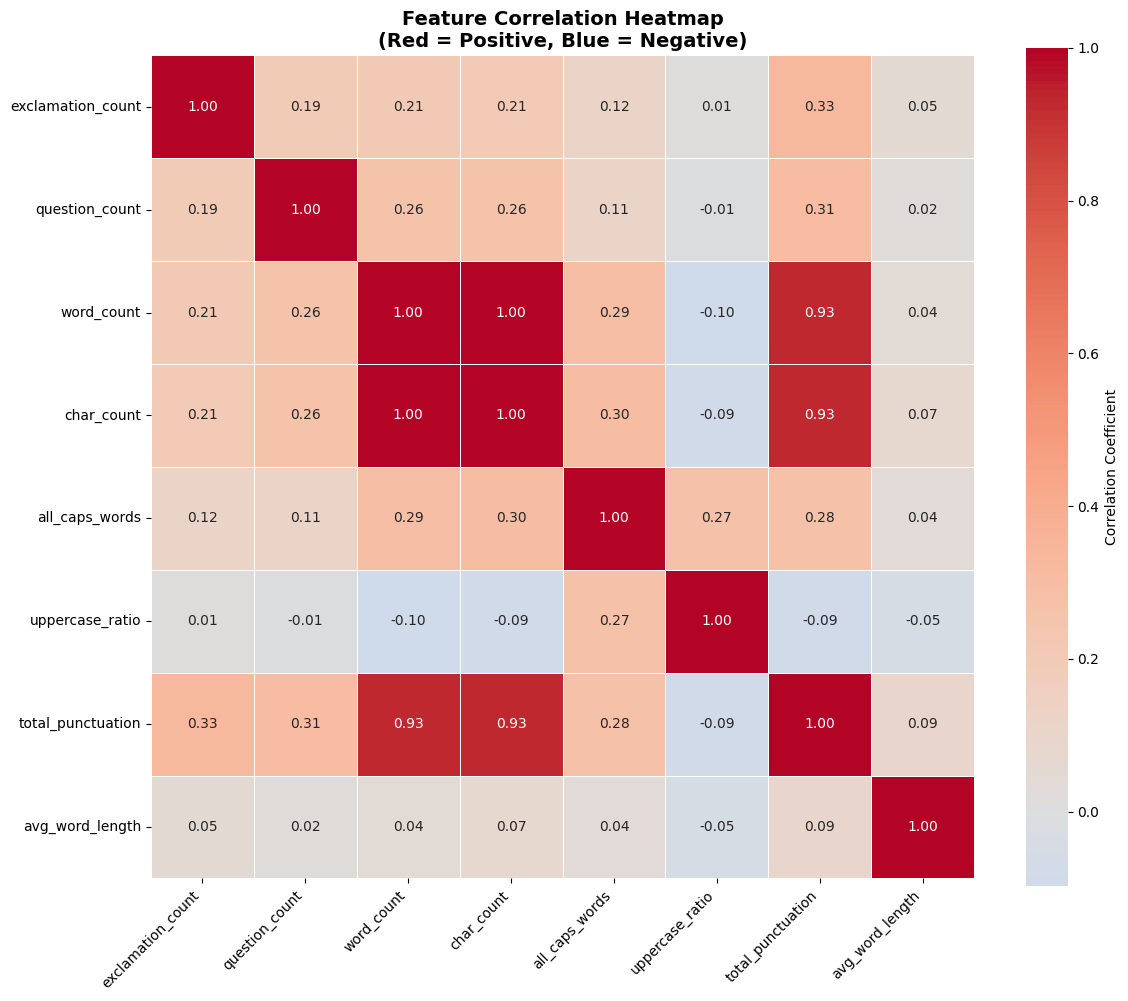

In [46]:
# Create correlation matrix
corr_matrix = df[text_features].corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix,
            annot=True,           # Show correlation values
            fmt='.2f',            # 2 decimal places
            cmap='coolwarm',      # Color scheme
            center=0,             # Center colormap at 0
            square=True,          # Make cells square
            linewidths=0.5,       # Grid lines
            cbar_kws={'label': 'Correlation Coefficient'})

plt.title('Feature Correlation Heatmap\n(Red = Positive, Blue = Negative)',
          fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
# Save the file
plt.savefig("multicolinarity_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
numeric_cols = ['rating', 'token_count', 'helpful_vote']
df[numeric_cols].describe()


,rating,token_count,helpful_vote
count,16949.000000,16949.000000,16949.000000
mean,4.321081,31.948965,1.734911
std,1.163135,49.911423,12.801548
min,1.000000,1.000000,0.000000
25%,4.000000,6.000000,0.000000
50%,5.000000,16.000000,0.000000
75%,5.000000,37.000000,1.000000
max,5.000000,1029.000000,929.000000


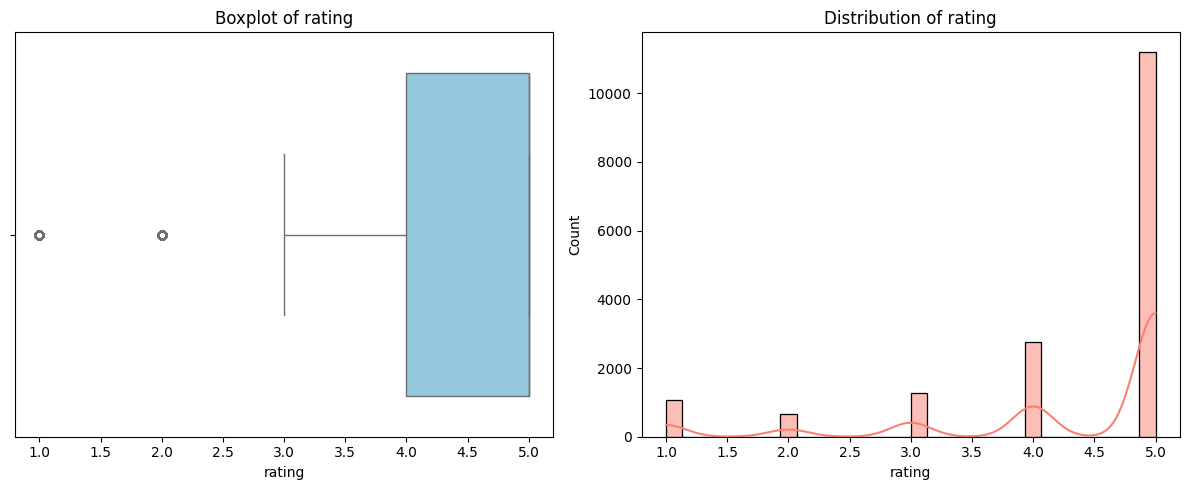

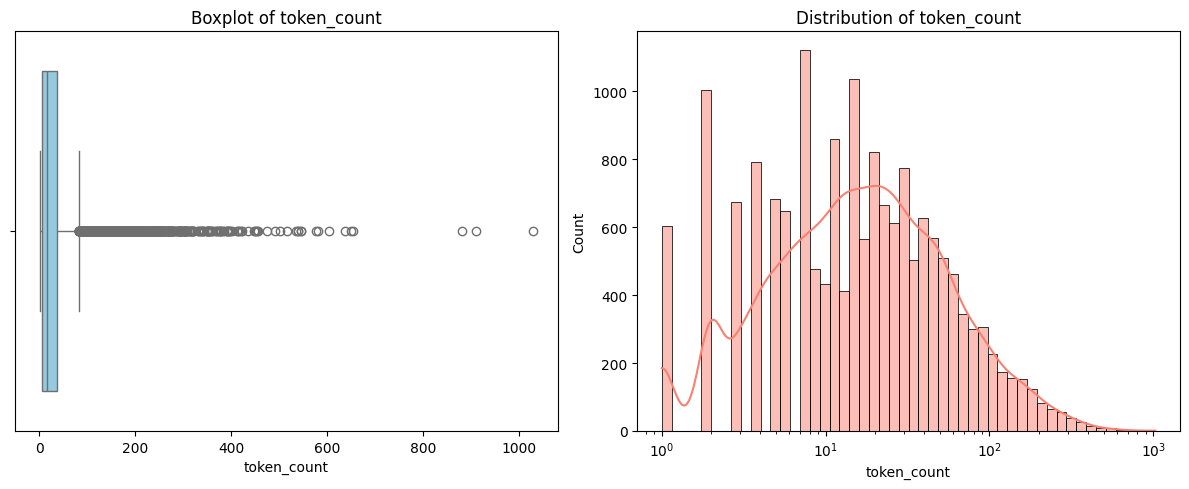

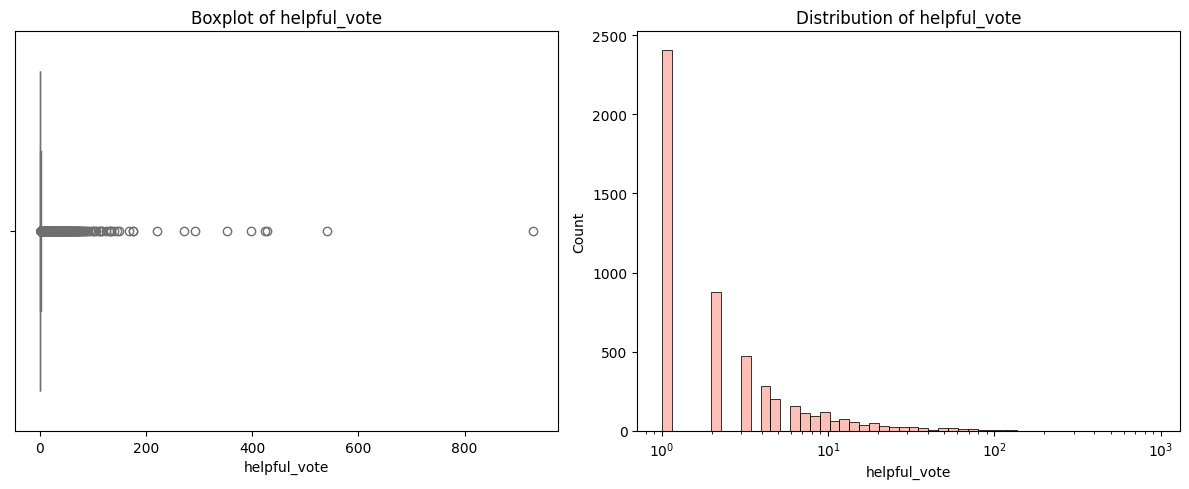

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize(feature):
    plt.figure(figsize=(12, 5))

    # 1. Boxplot
    plt.subplot(1, 2, 1)
    sns.boxplot(x=df[feature], color='skyblue')
    plt.title(f'Boxplot of {feature}')
    plt.xlabel(feature)

    # 2. Histogram
    plt.subplot(1, 2, 2)

    # Decide whether to use log scale if data is heavily skewed
    if df[feature].max() / df[feature].mean() > 10:  # rough heuristic
        sns.histplot(df[feature], bins=50, log_scale=(True, False), kde=True, color='salmon')
    else:
        sns.histplot(df[feature], bins=30, kde=True, color='salmon')

    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)

    plt.tight_layout()
    plt.show()

# Apply to all numeric features
numeric_features = df.select_dtypes(include=['number']).columns.tolist()
for feature in numeric_features:
    visualize(feature)


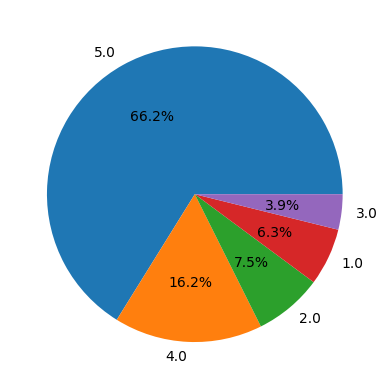

In [ ]:
#df['rating'] = df['rating'].apply(ratings)
plt.pie(df['rating'].value_counts(), labels=df['rating'].unique().tolist(), autopct='%1.1f%%')
plt.show()

/tmp/ipython-input-303135124.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='rating', palette='viridis')


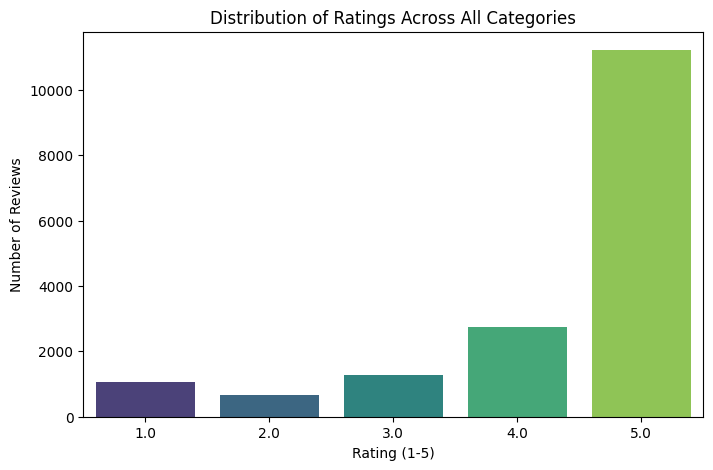

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='rating', palette='viridis')
plt.title('Distribution of Ratings Across All Categories')
plt.xlabel('Rating (1-5)')
plt.ylabel('Number of Reviews')
plt.show()

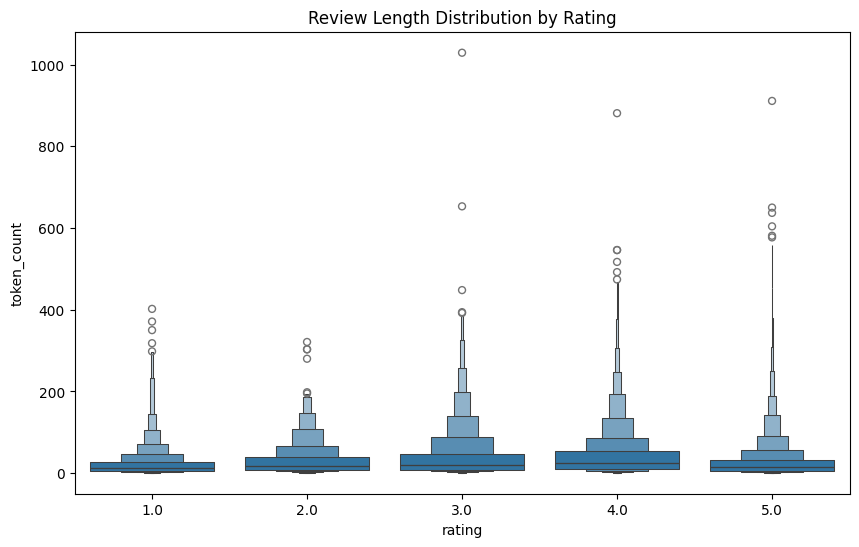

In [ ]:
# review length distribution by rating: most are short
# 5-stars reviews have greaties variance
plt.figure(figsize=(10, 6))
sns.boxenplot(x='rating', y='token_count', data=df)
plt.title('Review Length Distribution by Rating')
plt.show()

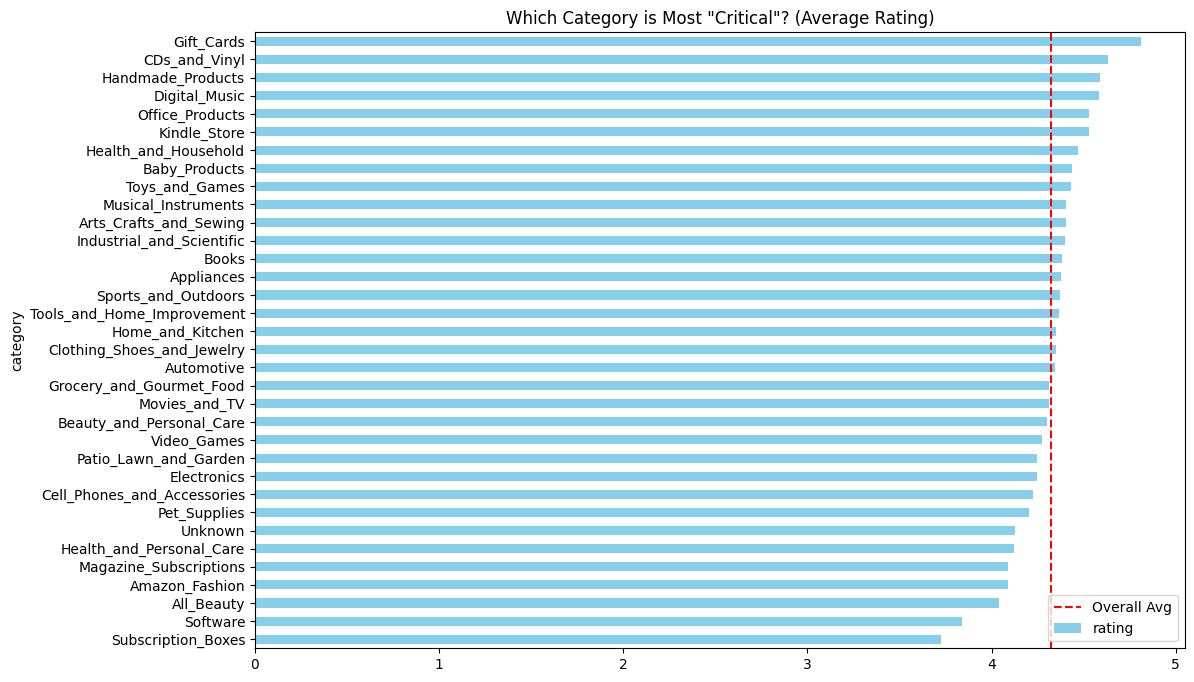

In [ ]:
# compare the average rating across different categories
# the red line represent the average rating of all reviews
plt.figure(figsize=(12, 8))
df.groupby('category')['rating'].mean().sort_values().plot(kind='barh', color='skyblue')
plt.axvline(x=df['rating'].mean(), color='red', linestyle='--', label='Overall Avg')
plt.title('Which Category is Most "Critical"? (Average Rating)')
plt.legend()
plt.show()

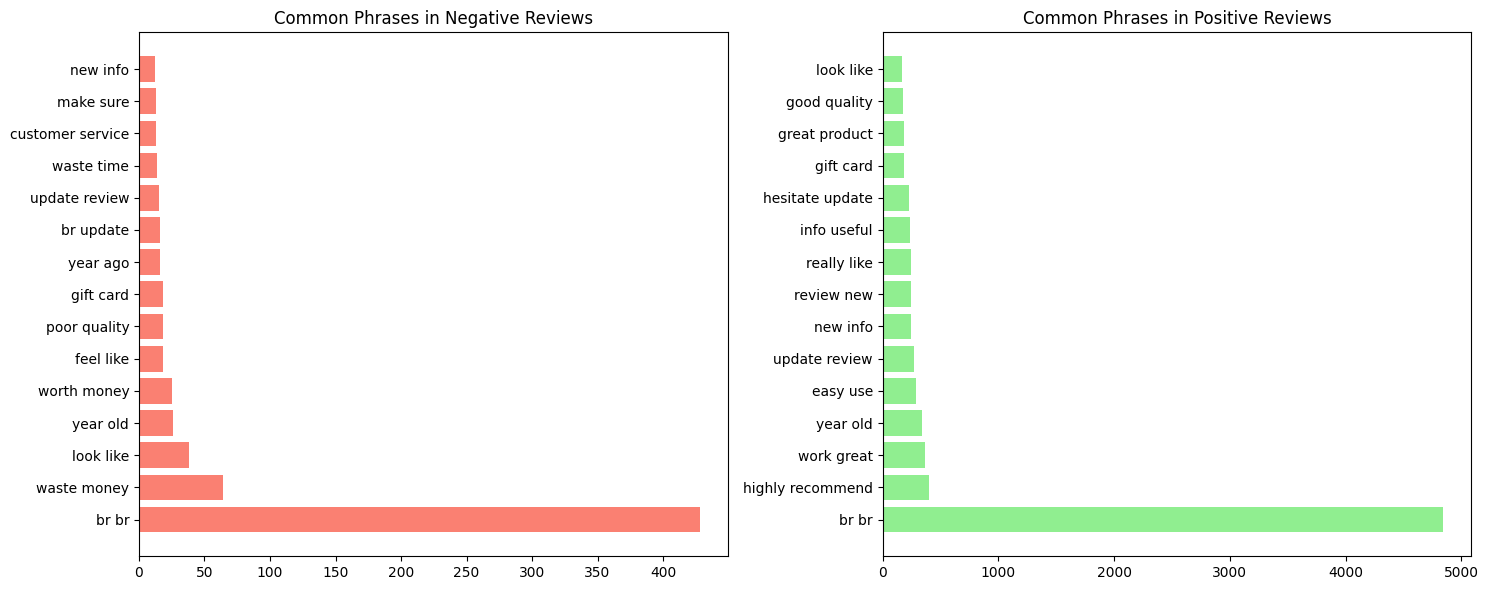

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def plot_top_bigrams(rating_range, title, color):
    subset = df[df['rating'].isin(rating_range)]['text_cleaned']
    cv = CountVectorizer(ngram_range=(2, 2), stop_words='english', max_features=15)
    bag_of_words = cv.fit_transform(subset)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

    words, counts = zip(*words_freq)
    plt.barh(words, counts, color=color)
    plt.title(title)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plot_top_bigrams([1, 2], "Common Phrases in Negative Reviews", "salmon")
plt.subplot(1, 2, 2)
plot_top_bigrams([4, 5], "Common Phrases in Positive Reviews", "lightgreen")
plt.tight_layout()
plt.show()

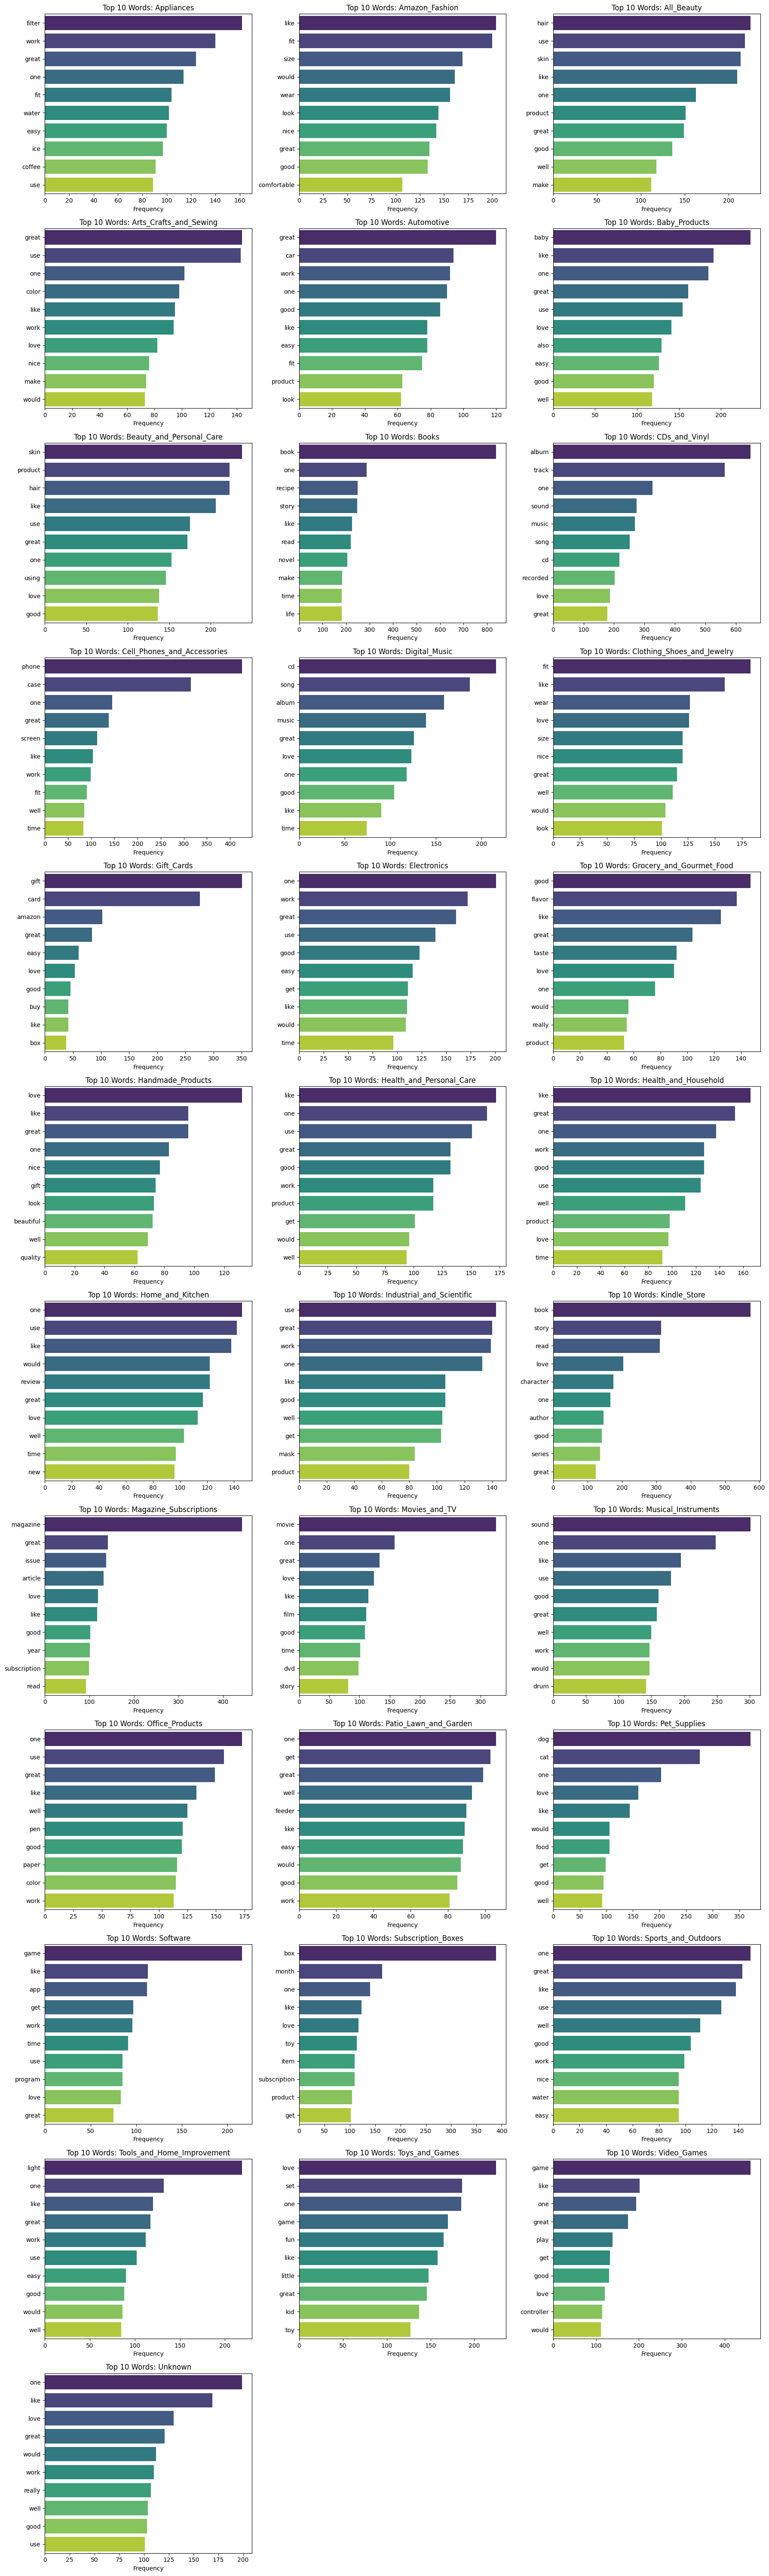

In [34]:
# top 10 common words
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Get the list of unique categories
categories = df['category'].unique()
n_categories = len(categories)

# Create subplots - adjust rows and columns based on number of categories
# For example, if you have 6 categories, you could do 2 rows x 3 columns
n_cols = 3  # adjust this
n_rows = (n_categories + n_cols - 1) // n_cols  # automatically calculate rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
axes = axes.flatten()  # Make it easier to iterate

for idx, cat in enumerate(categories):
    # 1. Filter the dataframe for the specific category
    cat_reviews = df[df['category'] == cat]['text_cleaned']

    # 2. Flatten the reviews into a single list of words
    all_text = " ".join(cat_reviews)
    all_text = all_text.replace('br', ' ')
    all_words = all_text.split()

    # 3. Count frequencies
    most_common = Counter(all_words).most_common(10)

    # 4. Prepare data for plotting
    words = [word for word, count in most_common]
    freq = [count for word, count in most_common]

    # 5. Plot on the specific subplot
    sns.barplot(x=freq, y=words, hue=words, palette='viridis',
                legend=False, ax=axes[idx])
    axes[idx].set_title(f'Top 10 Words: {cat}')
    axes[idx].set_xlabel('Frequency')
    axes[idx].set_ylabel('')

# Hide any unused subplots
for idx in range(n_categories, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

User Behavior


4. USER ACTIVITY ANALYSIS

Total unique users: 5,810
Total reviews: 16,949
Average reviews per user: 2.92
Median reviews per user: 1

Reviews per User Distribution:
count    5810.000000
mean        2.917212
std        14.939271
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max       650.000000
dtype: float64

User Categories:
One-time reviewers (1 review): 4,137 (71.2%)
Casual users (2-5 reviews): 1,256 (21.6%)
Active users (6-20 reviews): 330 (5.7%)
Power users (20+ reviews): 87 (1.5%)

Top 10 Most Active Users:
1. User AFZUK3MTBIBEDQOPAK3O...: 650 reviews
2. User AHV6QCNBJNSGLATP56JA...: 612 reviews
3. User AFJBKPK5W56XWSNPQU2W...: 312 reviews
4. User AHATA6X6MYTC3VNBFJ3W...: 238 reviews
5. User AFSKPY37N3C43SOI5IEX...: 234 reviews
6. User AFFZVSTUS3U2ZD22A2NP...: 179 reviews
7. User AFXF3EGQTQDXMRLDWFU7...: 176 reviews
8. User AG3S4FROO422V5KP7DJC...: 137 reviews
9. User AHJQPUQLSQZE6LMIUMY7...: 134 reviews
10. User AEICZD35OTDYVWA2KPYW...: 128

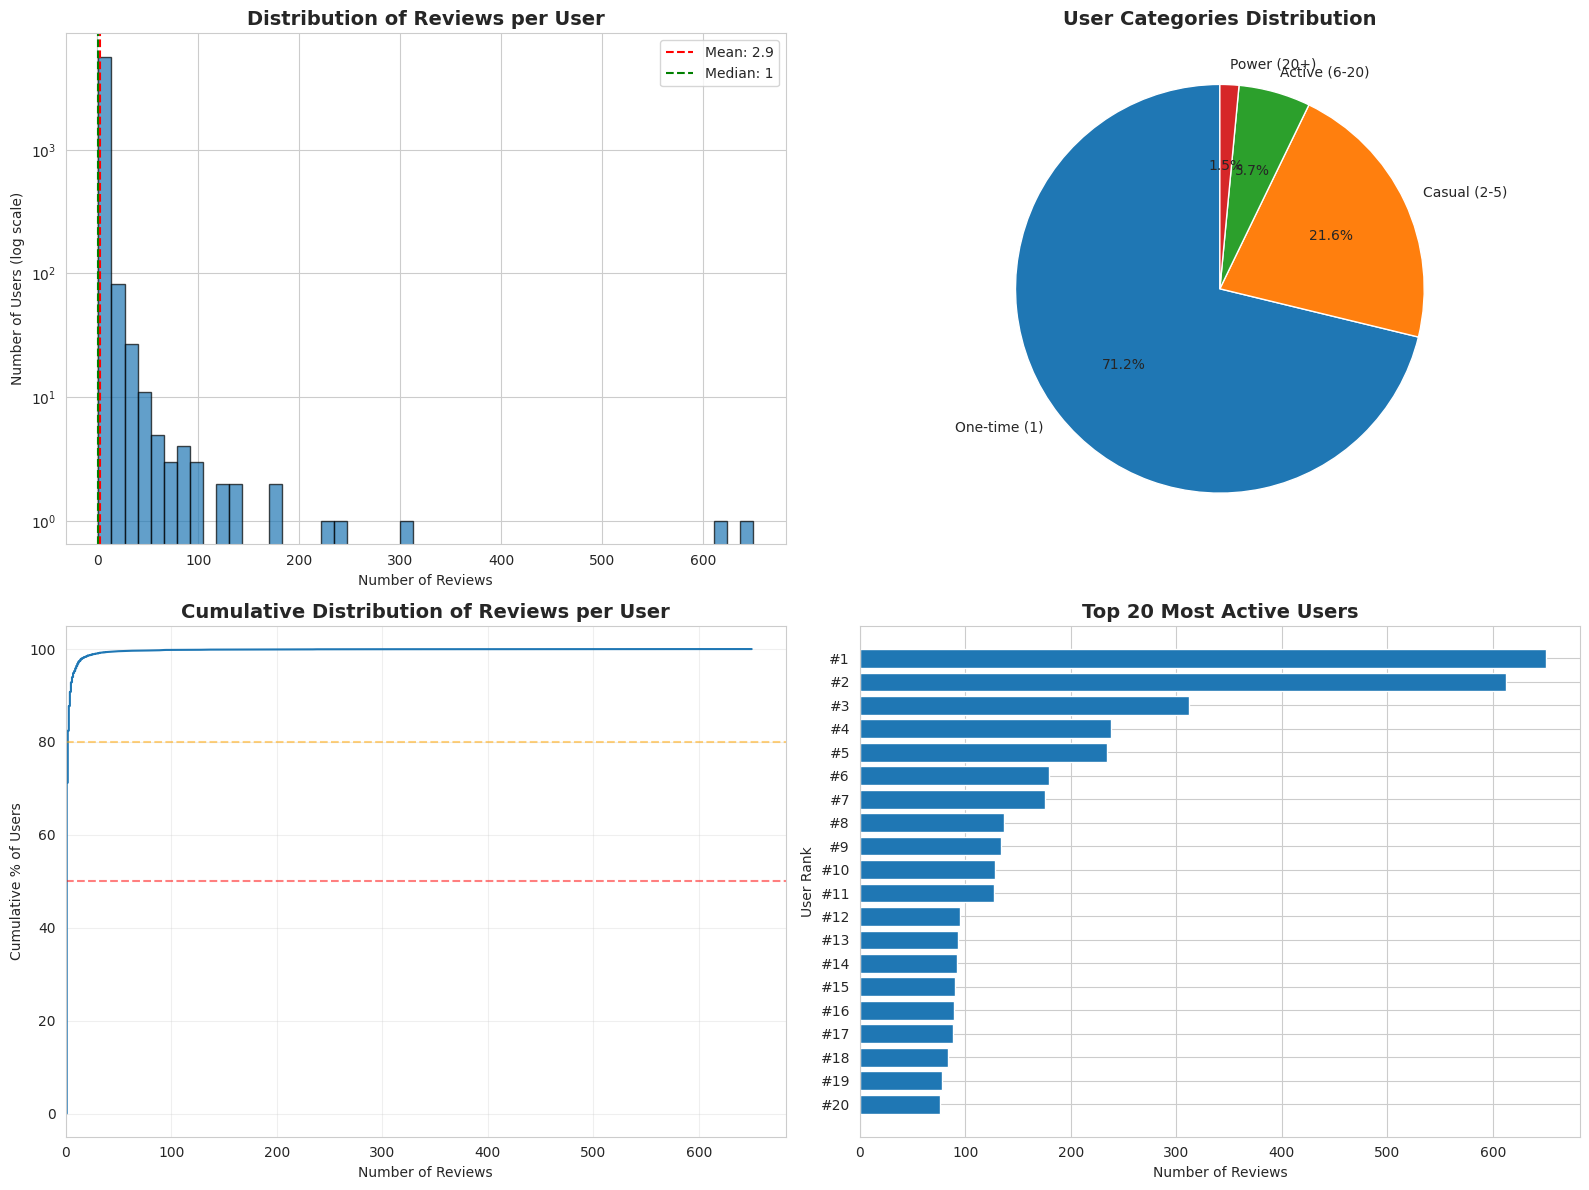


Pareto Analysis (80/20 Rule):
2,420 users (41.7%) account for 80% of all reviews
These users write an average of 5.6 reviews each


In [ ]:
# ==========================================
# 4. USER ACTIVITY ANALYSIS
# ==========================================

print("\n" + "=" * 60)
print("4. USER ACTIVITY ANALYSIS")
print("=" * 60)

# Reviews per user
reviews_per_user = df.groupby('user_id').size()

print(f"\nTotal unique users: {len(reviews_per_user):,}")
print(f"Total reviews: {len(df):,}")
print(f"Average reviews per user: {reviews_per_user.mean():.2f}")
print(f"Median reviews per user: {reviews_per_user.median():.0f}")

# Distribution statistics
print("\nReviews per User Distribution:")
print(reviews_per_user.describe())
# User categories
one_time_users = (reviews_per_user == 1).sum()
casual_users = ((reviews_per_user >= 2) & (reviews_per_user <= 5)).sum()
active_users = ((reviews_per_user >= 6) & (reviews_per_user <= 20)).sum()
power_users = (reviews_per_user > 20).sum()

print(f"\nUser Categories:")
print(f"One-time reviewers (1 review): {one_time_users:,} ({one_time_users/len(reviews_per_user)*100:.1f}%)")
print(f"Casual users (2-5 reviews): {casual_users:,} ({casual_users/len(reviews_per_user)*100:.1f}%)")
print(f"Active users (6-20 reviews): {active_users:,} ({active_users/len(reviews_per_user)*100:.1f}%)")
print(f"Power users (20+ reviews): {power_users:,} ({power_users/len(reviews_per_user)*100:.1f}%)")

# Top reviewers
print("\nTop 10 Most Active Users:")
top_reviewers = reviews_per_user.nlargest(10)
for i, (user_id, count) in enumerate(top_reviewers.items(), 1):
    print(f"{i}. User {user_id[:20]}...: {count} reviews")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
# Histogram - Reviews per user (log scale)
axes[0, 0].hist(reviews_per_user, bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribution of Reviews per User', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Number of Reviews')
axes[0, 0].set_ylabel('Number of Users (log scale)')
axes[0, 0].set_yscale('log')
axes[0, 0].axvline(reviews_per_user.mean(), color='red', linestyle='--', label=f'Mean: {reviews_per_user.mean():.1f}')
axes[0, 0].axvline(reviews_per_user.median(), color='green', linestyle='--', label=f'Median: {reviews_per_user.median():.0f}')
axes[0, 0].legend()

# User category pie chart
user_categories = pd.Series({
    'One-time (1)': one_time_users,
    'Casual (2-5)': casual_users,
    'Active (6-20)': active_users,
    'Power (20+)': power_users
})
axes[0, 1].pie(user_categories, labels=user_categories.index, autopct='%1.1f%%', startangle=90)
axes[0, 1].set_title('User Categories Distribution', fontsize=14, fontweight='bold')
# CDF - Cumulative distribution
sorted_reviews = np.sort(reviews_per_user)
cumulative = np.arange(1, len(sorted_reviews) + 1) / len(sorted_reviews) * 100
axes[1, 0].plot(sorted_reviews, cumulative)
axes[1, 0].set_title('Cumulative Distribution of Reviews per User', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Number of Reviews')
axes[1, 0].set_ylabel('Cumulative % of Users')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].axhline(50, color='red', linestyle='--', alpha=0.5)
axes[1, 0].axhline(80, color='orange', linestyle='--', alpha=0.5)
axes[1, 0].set_xlim(left=0)

# Top 20 reviewers bar plot
top_20 = reviews_per_user.nlargest(20)
axes[1, 1].barh(range(len(top_20)), top_20.values)
axes[1, 1].set_title('Top 20 Most Active Users', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Number of Reviews')
axes[1, 1].set_ylabel('User Rank')
axes[1, 1].invert_yaxis()
axes[1, 1].set_yticks(range(len(top_20)))
axes[1, 1].set_yticklabels([f'#{i+1}' for i in range(len(top_20))])
plt.tight_layout()
plt.show()

# Pareto analysis (80/20 rule)
sorted_users = reviews_per_user.sort_values(ascending=False)
cumsum = sorted_users.cumsum()
total_reviews = sorted_users.sum()

users_for_80pct = (cumsum <= total_reviews * 0.8).sum()
pct_users_for_80pct = users_for_80pct / len(sorted_users) * 100

print(f"\nPareto Analysis (80/20 Rule):")
print(f"{users_for_80pct:,} users ({pct_users_for_80pct:.1f}%) account for 80% of all reviews")
print(f"These users write an average of {sorted_users.head(users_for_80pct).mean():.1f} reviews each")



5. COMBINED USER BEHAVIOR INSIGHTS

User Behavior by Category:
               % Verified  Avg Rating  Avg Helpful Votes  Avg Text Length
user_category                                                            
One-time             0.90        4.26               1.74            17.76
Casual               0.88        4.25               1.08            19.82
Active               0.83        4.31               1.62            23.05
Power                0.41        4.42               2.18            53.82


/tmp/ipython-input-845524480.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  user_behavior_summary = df.groupby('user_category').agg({


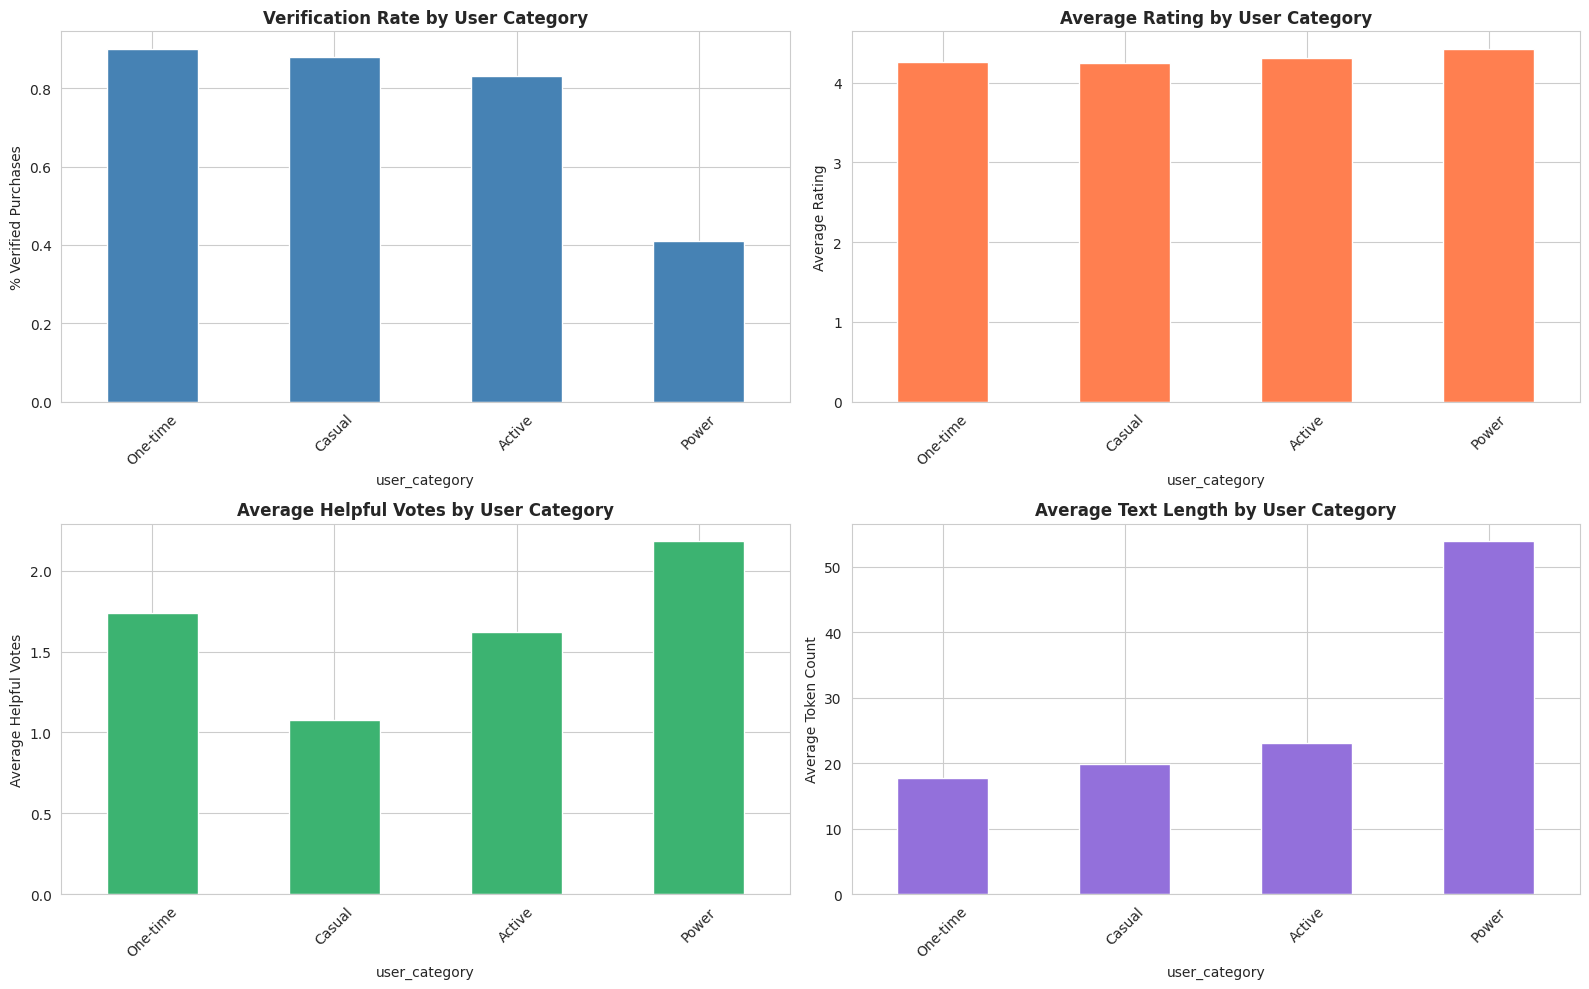


ANALYSIS COMPLETE


In [ ]:
# ==========================================
# 5. COMBINED ANALYSIS
# ==========================================

print("\n" + "=" * 60)
print("5. COMBINED USER BEHAVIOR INSIGHTS")
print("=" * 60)

# Power users vs verification
df['user_review_count'] = df.groupby('user_id')['user_id'].transform('count')
df['user_category'] = pd.cut(df['user_review_count'],
                               bins=[0, 1, 5, 20, float('inf')],
                               labels=['One-time', 'Casual', 'Active', 'Power'])

user_behavior_summary = df.groupby('user_category').agg({
    'verified_purchase': 'mean',
    'rating': 'mean',
    'helpful_vote': 'mean',
    'token_count': 'mean'
}).round(2)

user_behavior_summary.columns = ['% Verified', 'Avg Rating', 'Avg Helpful Votes', 'Avg Text Length']
print("\nUser Behavior by Category:")
print(user_behavior_summary)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

user_behavior_summary['% Verified'].plot(kind='bar', ax=axes[0, 0], color='steelblue')
axes[0, 0].set_title('Verification Rate by User Category', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('% Verified Purchases')
axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=45)

user_behavior_summary['Avg Rating'].plot(kind='bar', ax=axes[0, 1], color='coral')
axes[0, 1].set_title('Average Rating by User Category', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Average Rating')
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=45)

user_behavior_summary['Avg Helpful Votes'].plot(kind='bar', ax=axes[1, 0], color='mediumseagreen')
axes[1, 0].set_title('Average Helpful Votes by User Category', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Average Helpful Votes')
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=45)

user_behavior_summary['Avg Text Length'].plot(kind='bar', ax=axes[1, 1], color='mediumpurple')
axes[1, 1].set_title('Average Text Length by User Category', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Average Token Count')
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

Product
ASIN: Amazon Standard Identification Number

1. REVIEWS PER PRODUCT (ASIN) DISTRIBUTION

Total unique products (ASINs): 15,793
Total reviews: 16,949
Average reviews per product: 1.07
Median reviews per product: 1

Reviews per Product Distribution:
count    15793.000000
mean         1.073197
std          1.196854
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        104.000000
dtype: float64

Percentiles:
25th percentile: 1 reviews
50th percentile: 1 reviews
75th percentile: 1 reviews
90th percentile: 1 reviews
95th percentile: 1 reviews
99th percentile: 3 reviews

Product Categories by Review Count:
Single review (1): 15,332 (97.1%)
Low reviews (2-5): 421 (2.7%)
Medium reviews (6-20): 36 (0.2%)
High reviews (20+): 4 (0.0%)


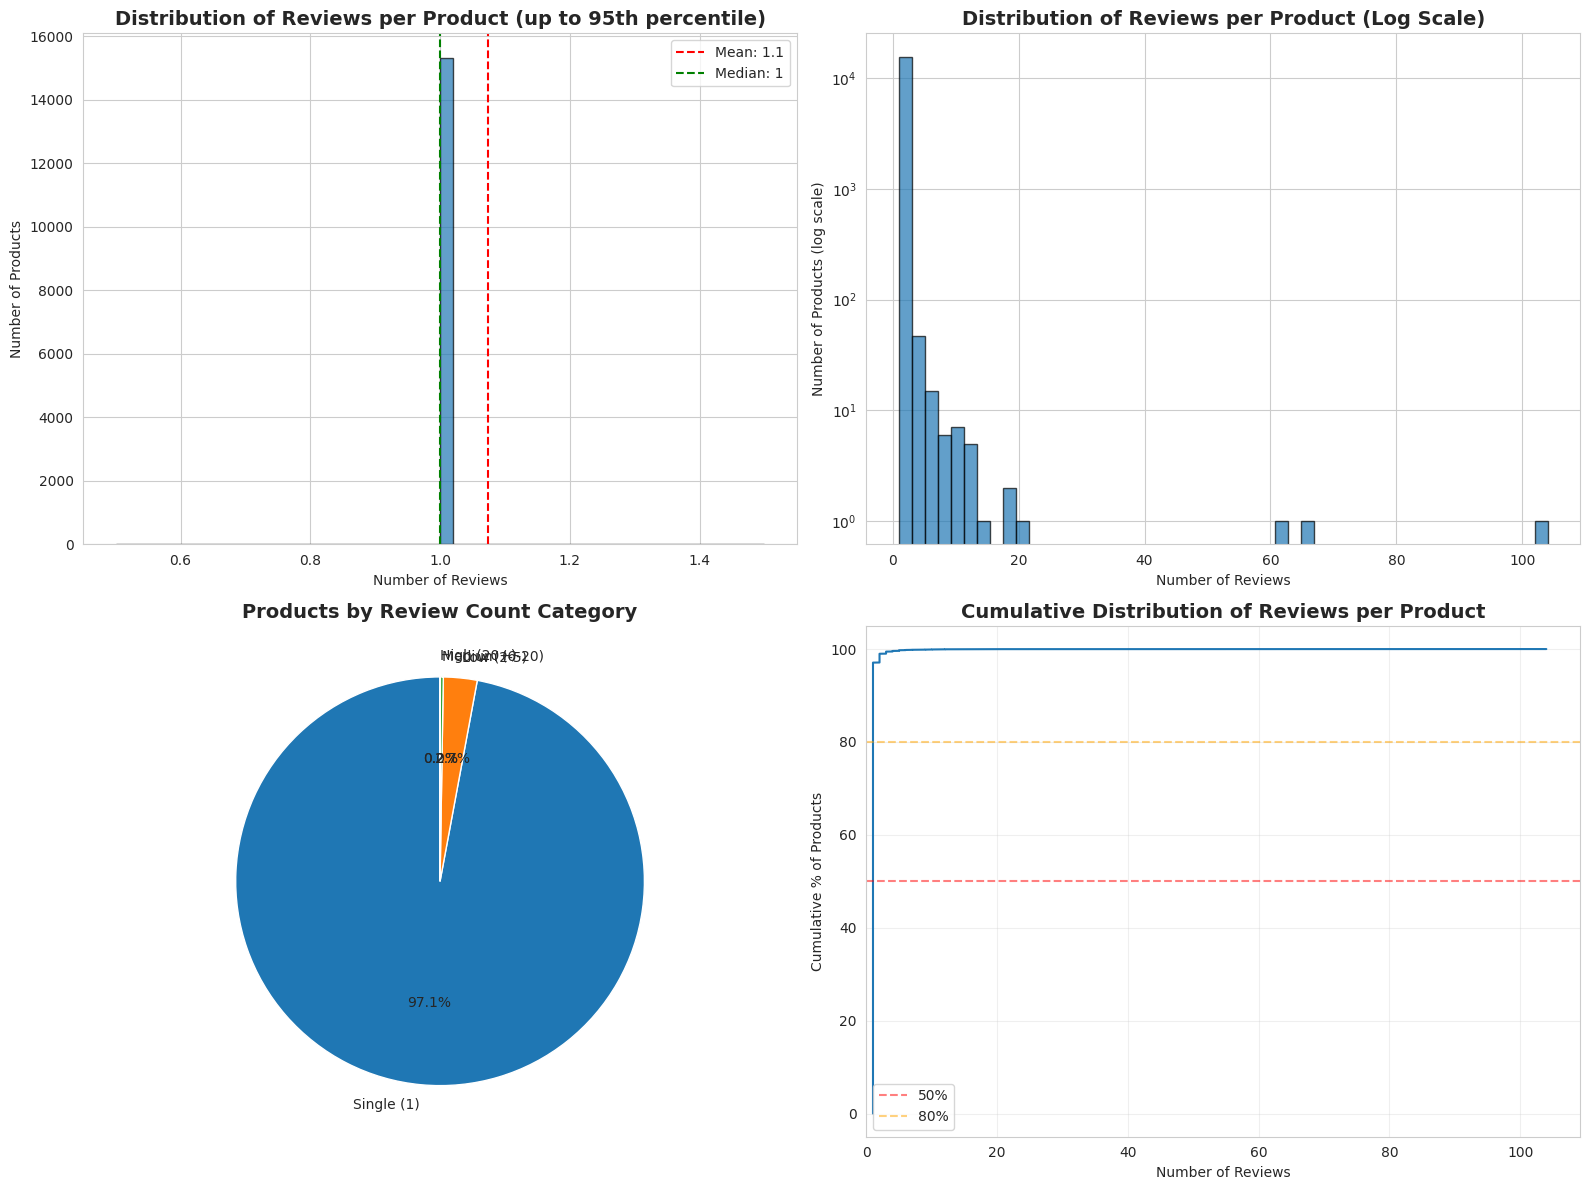

In [ ]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

#
# REVIEWS PER PRODUCT (ASIN)

print("=" * 60)
print("1. REVIEWS PER PRODUCT (ASIN) DISTRIBUTION")
print("=" * 60)

# Calculate reviews per product
reviews_per_product = df.groupby('asin').size()

print(f"\nTotal unique products (ASINs): {len(reviews_per_product):,}")
print(f"Total reviews: {len(df):,}")
print(f"Average reviews per product: {reviews_per_product.mean():.2f}")
print(f"Median reviews per product: {reviews_per_product.median():.0f}")

# Distribution statistics
print("\nReviews per Product Distribution:")
print(reviews_per_product.describe())

# Percentiles
percentiles = [25, 50, 75, 90, 95, 99]
print("\nPercentiles:")
for p in percentiles:
    value = reviews_per_product.quantile(p/100)
    print(f"{p}th percentile: {value:.0f} reviews")

# Product categories by review count
single_review_products = (reviews_per_product == 1).sum()
low_review_products = ((reviews_per_product >= 2) & (reviews_per_product <= 5)).sum()
medium_review_products = ((reviews_per_product >= 6) & (reviews_per_product <= 20)).sum()
high_review_products = (reviews_per_product > 20).sum()

print(f"\nProduct Categories by Review Count:")
print(f"Single review (1): {single_review_products:,} ({single_review_products/len(reviews_per_product)*100:.1f}%)")
print(f"Low reviews (2-5): {low_review_products:,} ({low_review_products/len(reviews_per_product)*100:.1f}%)")
print(f"Medium reviews (6-20): {medium_review_products:,} ({medium_review_products/len(reviews_per_product)*100:.1f}%)")
print(f"High reviews (20+): {high_review_products:,} ({high_review_products/len(reviews_per_product)*100:.1f}%)")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Histogram (limited range for visibility)
max_display = reviews_per_product.quantile(0.95)
axes[0, 0].hist(reviews_per_product[reviews_per_product <= max_display], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_title(f'Distribution of Reviews per Product (up to 95th percentile)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Number of Reviews')
axes[0, 0].set_ylabel('Number of Products')
axes[0, 0].axvline(reviews_per_product.mean(), color='red', linestyle='--', label=f'Mean: {reviews_per_product.mean():.1f}')
axes[0, 0].axvline(reviews_per_product.median(), color='green', linestyle='--', label=f'Median: {reviews_per_product.median():.0f}')
axes[0, 0].legend()

# Log-scale histogram (full range)
axes[0, 1].hist(reviews_per_product, bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Distribution of Reviews per Product (Log Scale)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Number of Reviews')
axes[0, 1].set_ylabel('Number of Products (log scale)')
axes[0, 1].set_yscale('log')

# Product category pie chart
product_categories = pd.Series({
    'Single (1)': single_review_products,
    'Low (2-5)': low_review_products,
    'Medium (6-20)': medium_review_products,
    'High (20+)': high_review_products
})
axes[1, 0].pie(product_categories, labels=product_categories.index, autopct='%1.1f%%', startangle=90)
axes[1, 0].set_title('Products by Review Count Category', fontsize=14, fontweight='bold')

# Cumulative distribution
sorted_products = np.sort(reviews_per_product)
cumulative = np.arange(1, len(sorted_products) + 1) / len(sorted_products) * 100
axes[1, 1].plot(sorted_products, cumulative)
axes[1, 1].set_title('Cumulative Distribution of Reviews per Product', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Number of Reviews')
axes[1, 1].set_ylabel('Cumulative % of Products')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].axhline(50, color='red', linestyle='--', alpha=0.5, label='50%')
axes[1, 1].axhline(80, color='orange', linestyle='--', alpha=0.5, label='80%')
axes[1, 1].legend()
axes[1, 1].set_xlim(left=0)

plt.tight_layout()
plt.show()

2. AVERAGE RATING PER PRODUCT ANALYSIS

Average Rating Distribution Across Products:
count    15793.00000
mean         4.32790
std          1.13989
min          1.00000
25%          4.00000
50%          5.00000
75%          5.00000
max          5.00000
Name: avg_rating, dtype: float64

Product Rating Categories:
High-rated (≥4.5): 10,377 (65.7%)
Medium-rated (2.5-4.5): 3,893 (24.7%)
Low-rated (≤2.5): 1,523 (9.6%)

--- Top 10 Highest-Rated Products (min 5 reviews) ---
ASIN: B002PXVYQY | Avg Rating: 5.00 | Reviews: 6
ASIN: B0061SHL16 | Avg Rating: 5.00 | Reviews: 5
ASIN: B00QW8TYWO | Avg Rating: 5.00 | Reviews: 5
ASIN: B014S24B28 | Avg Rating: 5.00 | Reviews: 5
ASIN: B01K8RJDEI | Avg Rating: 5.00 | Reviews: 10
ASIN: B01K8RL9C2 | Avg Rating: 5.00 | Reviews: 5
ASIN: B06WVJBLBQ | Avg Rating: 5.00 | Reviews: 6
ASIN: B071VCQJ24 | Avg Rating: 5.00 | Reviews: 5
ASIN: B072P5VV4D | Avg Rating: 5.00 | Reviews: 6
ASIN: B07FK7L976 | Avg Rating: 5.00 | Reviews: 5

--- Top 10 Lowest-Rated Products (mi

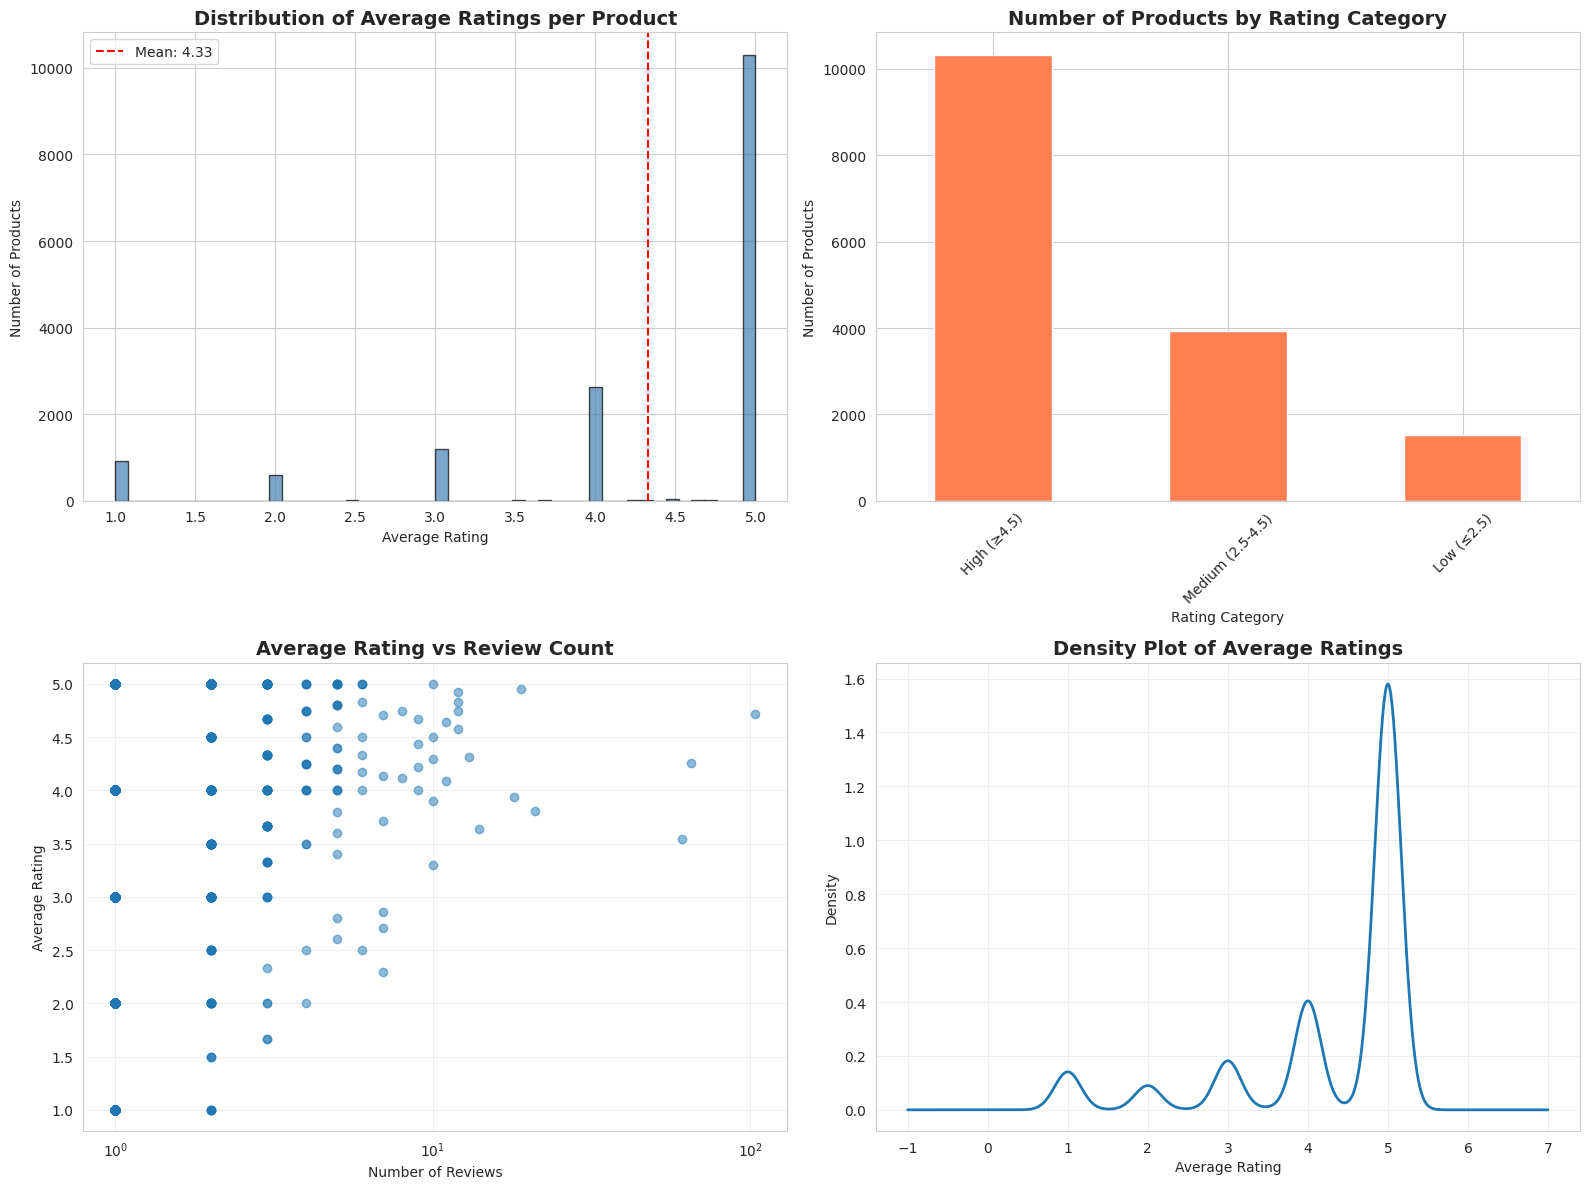

In [ ]:

# AVERAGE RATING PER PRODUCT

print("=" * 60)
print("2. AVERAGE RATING PER PRODUCT ANALYSIS")
print("=" * 60)

# Calculate average rating per product
product_stats = df.groupby('asin').agg({
    'rating': ['mean', 'median', 'std', 'count', 'min', 'max']
}).round(2)

product_stats.columns = ['avg_rating', 'median_rating', 'std_rating', 'review_count', 'min_rating', 'max_rating']
product_stats = product_stats.reset_index()

print("\nAverage Rating Distribution Across Products:")
print(product_stats['avg_rating'].describe())

# Products with extreme ratings
high_rated_products = (product_stats['avg_rating'] >= 4.5).sum()
low_rated_products = (product_stats['avg_rating'] <= 2.5).sum()
medium_rated_products = ((product_stats['avg_rating'] > 2.5) & (product_stats['avg_rating'] < 4.5)).sum()

print(f"\nProduct Rating Categories:")
print(f"High-rated (≥4.5): {high_rated_products:,} ({high_rated_products/len(product_stats)*100:.1f}%)")
print(f"Medium-rated (2.5-4.5): {medium_rated_products:,} ({medium_rated_products/len(product_stats)*100:.1f}%)")
print(f"Low-rated (≤2.5): {low_rated_products:,} ({low_rated_products/len(product_stats)*100:.1f}%)")

# Top and bottom products by rating (with minimum review threshold)
min_reviews_threshold = 5
qualified_products = product_stats[product_stats['review_count'] >= min_reviews_threshold]

print(f"\n--- Top 10 Highest-Rated Products (min {min_reviews_threshold} reviews) ---")
top_rated = qualified_products.nlargest(10, 'avg_rating')[['asin', 'avg_rating', 'review_count']]
for idx, row in top_rated.iterrows():
    print(f"ASIN: {row['asin']} | Avg Rating: {row['avg_rating']:.2f} | Reviews: {int(row['review_count'])}")

print(f"\n--- Top 10 Lowest-Rated Products (min {min_reviews_threshold} reviews) ---")
bottom_rated = qualified_products.nsmallest(10, 'avg_rating')[['asin', 'avg_rating', 'review_count']]
for idx, row in bottom_rated.iterrows():
    print(f"ASIN: {row['asin']} | Avg Rating: {row['avg_rating']:.2f} | Reviews: {int(row['review_count'])}")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Histogram of average ratings
axes[0, 0].hist(product_stats['avg_rating'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].set_title('Distribution of Average Ratings per Product', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Average Rating')
axes[0, 0].set_ylabel('Number of Products')
axes[0, 0].axvline(product_stats['avg_rating'].mean(), color='red', linestyle='--',
                    label=f'Mean: {product_stats["avg_rating"].mean():.2f}')
axes[0, 0].legend()

# Box plot by rating category
product_stats['rating_category'] = pd.cut(product_stats['avg_rating'],
                                           bins=[0, 2.5, 4.5, 5.0],
                                           labels=['Low (≤2.5)', 'Medium (2.5-4.5)', 'High (≥4.5)'])
product_stats['rating_category'].value_counts().plot(kind='bar', ax=axes[0, 1], color='coral')
axes[0, 1].set_title('Number of Products by Rating Category', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Rating Category')
axes[0, 1].set_ylabel('Number of Products')
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=45)

# Scatter: Average rating vs Review count
axes[1, 0].scatter(product_stats['review_count'], product_stats['avg_rating'], alpha=0.5)
axes[1, 0].set_title('Average Rating vs Review Count', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Number of Reviews')
axes[1, 0].set_ylabel('Average Rating')
axes[1, 0].set_xscale('log')
axes[1, 0].grid(True, alpha=0.3)

# Density plot
product_stats['avg_rating'].plot(kind='kde', ax=axes[1, 1], linewidth=2)
axes[1, 1].set_title('Density Plot of Average Ratings', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Average Rating')
axes[1, 1].set_ylabel('Density')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

3. PRODUCT POPULARITY ANALYSIS

--- Top 20 Most Popular Products (by review count) ---
ASIN: B00IX1I3G6 | Reviews: 104 | Avg Rating: 4.72
ASIN: B079TRNVHX | Reviews: 65 | Avg Rating: 4.26
ASIN: B0742LVLMJ | Reviews: 61 | Avg Rating: 3.54
ASIN: B07G584SHG | Reviews: 21 | Avg Rating: 3.81
ASIN: B086KKT3RX | Reviews: 19 | Avg Rating: 4.95
ASIN: B01M71IUZ7 | Reviews: 18 | Avg Rating: 3.94
ASIN: B01M7UDAVI | Reviews: 14 | Avg Rating: 3.64
ASIN: B07F8Y6BH9 | Reviews: 13 | Avg Rating: 4.31
ASIN: B00005NIOH | Reviews: 12 | Avg Rating: 4.58
ASIN: B01M7UD21X | Reviews: 12 | Avg Rating: 4.75
ASIN: B01MSBQB1P | Reviews: 12 | Avg Rating: 4.83
ASIN: B0719C5P56 | Reviews: 12 | Avg Rating: 4.92
ASIN: B002CT515Q | Reviews: 11 | Avg Rating: 4.09
ASIN: B01C9MW8Z6 | Reviews: 11 | Avg Rating: 4.64
ASIN: B000063XJL | Reviews: 10 | Avg Rating: 3.90
ASIN: B002PXW1IE | Reviews: 10 | Avg Rating: 4.30
ASIN: B01K8RJDEI | Reviews: 10 | Avg Rating: 5.00
ASIN: B01K8RMDO0 | Reviews: 10 | Avg Rating: 4.50
ASIN: B07XGN

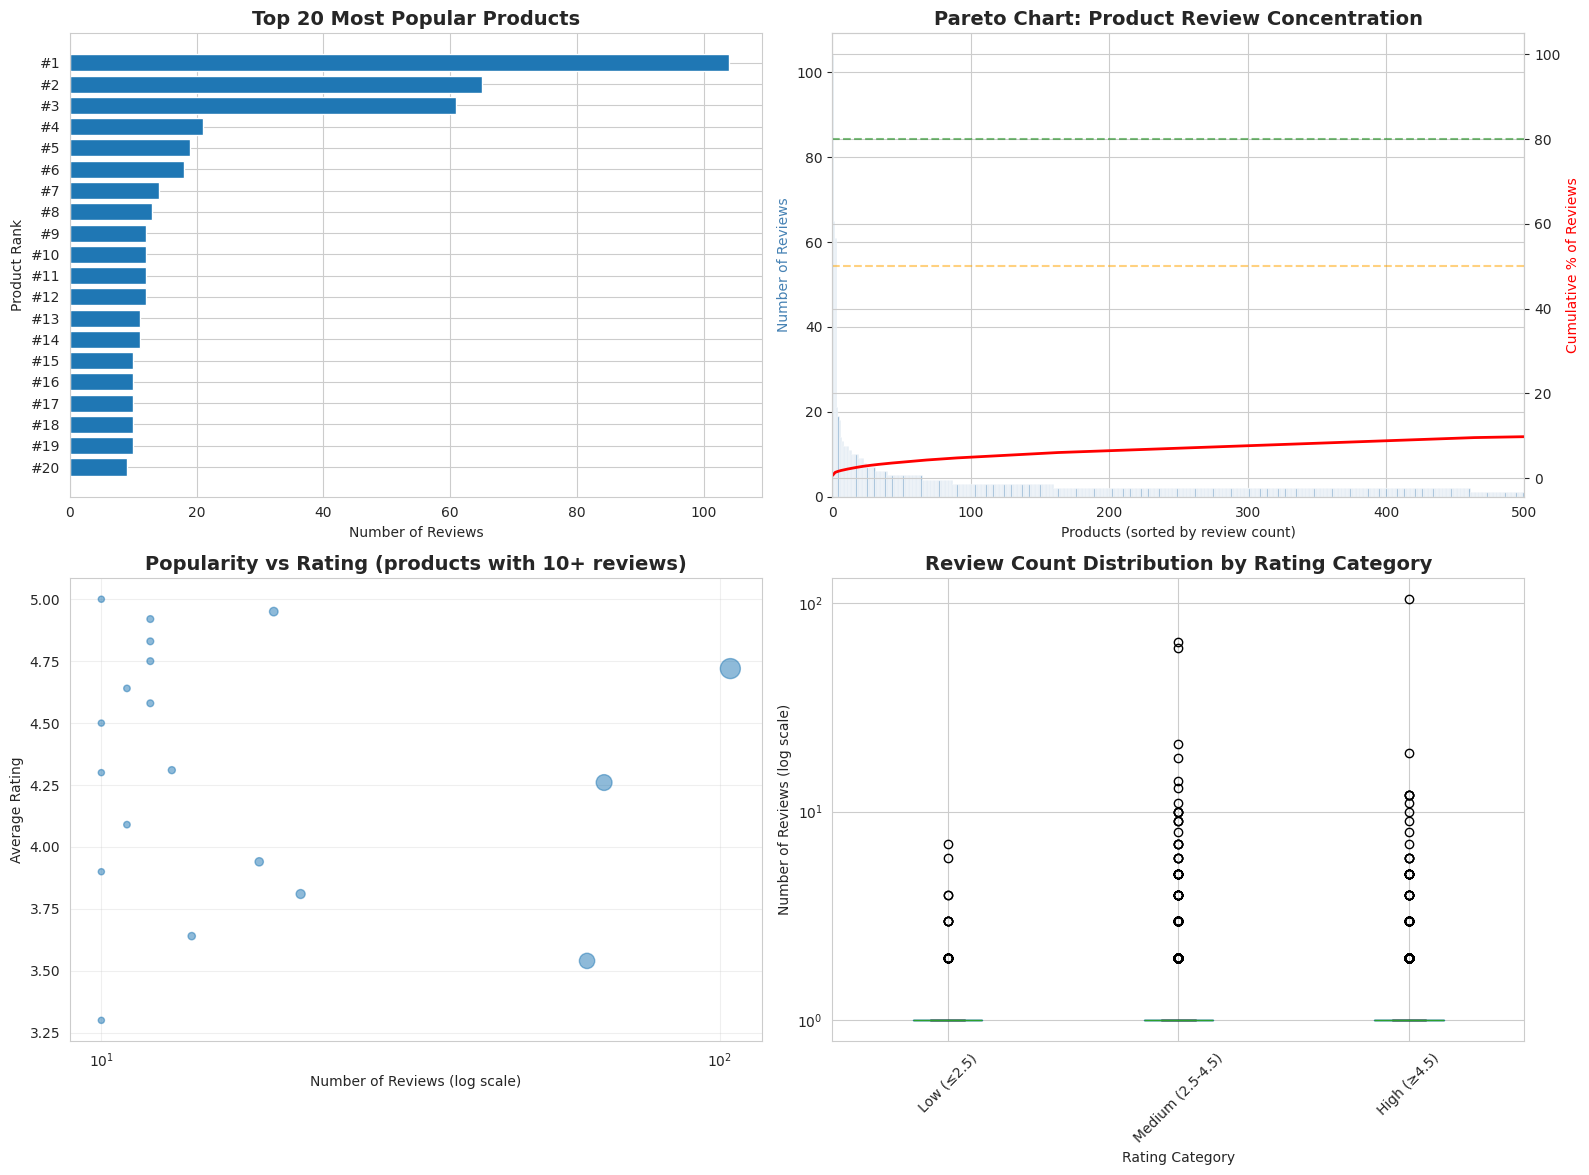

In [ ]:
# PRODUCT POPULARITY (MOST REVIEWS)

print("=" * 60)
print("3. PRODUCT POPULARITY ANALYSIS")
print("=" * 60)

# Most popular products
print("\n--- Top 20 Most Popular Products (by review count) ---")
top_popular = product_stats.nlargest(20, 'review_count')[['asin', 'review_count', 'avg_rating']]
for idx, row in top_popular.iterrows():
    print(f"ASIN: {row['asin']} | Reviews: {int(row['review_count'])} | Avg Rating: {row['avg_rating']:.2f}")

# Concentration analysis (Pareto)
sorted_products_by_reviews = product_stats.sort_values('review_count', ascending=False)
cumsum_reviews = sorted_products_by_reviews['review_count'].cumsum()
total_reviews = sorted_products_by_reviews['review_count'].sum()

products_for_50pct = (cumsum_reviews <= total_reviews * 0.5).sum()
products_for_80pct = (cumsum_reviews <= total_reviews * 0.8).sum()

print(f"\n--- Concentration Analysis (Pareto Principle) ---")
print(f"{products_for_50pct:,} products ({products_for_50pct/len(product_stats)*100:.1f}%) account for 50% of all reviews")
print(f"{products_for_80pct:,} products ({products_for_80pct/len(product_stats)*100:.1f}%) account for 80% of all reviews")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Top 20 products bar chart
top_20_popular = product_stats.nlargest(20, 'review_count')
axes[0, 0].barh(range(len(top_20_popular)), top_20_popular['review_count'].values)
axes[0, 0].set_title('Top 20 Most Popular Products', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Number of Reviews')
axes[0, 0].set_ylabel('Product Rank')
axes[0, 0].invert_yaxis()
axes[0, 0].set_yticks(range(len(top_20_popular)))
axes[0, 0].set_yticklabels([f'#{i+1}' for i in range(len(top_20_popular))])

# Pareto chart
sorted_by_reviews = product_stats.sort_values('review_count', ascending=False).reset_index(drop=True)
cumulative_pct = sorted_by_reviews['review_count'].cumsum() / sorted_by_reviews['review_count'].sum() * 100

ax1 = axes[0, 1]
ax2 = ax1.twinx()
ax1.bar(range(len(sorted_by_reviews)), sorted_by_reviews['review_count'], alpha=0.7, color='steelblue')
ax2.plot(range(len(sorted_by_reviews)), cumulative_pct, color='red', linewidth=2, marker='o', markersize=0)
ax1.set_title('Pareto Chart: Product Review Concentration', fontsize=14, fontweight='bold')
ax1.set_xlabel('Products (sorted by review count)')
ax1.set_ylabel('Number of Reviews', color='steelblue')
ax2.set_ylabel('Cumulative % of Reviews', color='red')
ax2.axhline(50, color='orange', linestyle='--', alpha=0.5)
ax2.axhline(80, color='green', linestyle='--', alpha=0.5)
ax1.set_xlim(0, min(len(sorted_by_reviews), 500))  # Show first 500 products

# Popularity vs Rating scatter (with size)
popular_products = product_stats[product_stats['review_count'] >= 10]
axes[1, 0].scatter(popular_products['review_count'], popular_products['avg_rating'],
                   s=popular_products['review_count']*2, alpha=0.5)
axes[1, 0].set_title('Popularity vs Rating (products with 10+ reviews)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Number of Reviews (log scale)')
axes[1, 0].set_ylabel('Average Rating')
axes[1, 0].set_xscale('log')
axes[1, 0].grid(True, alpha=0.3)

# Review count distribution by rating category
product_stats.boxplot(column='review_count', by='rating_category', ax=axes[1, 1])
axes[1, 1].set_title('Review Count Distribution by Rating Category', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Rating Category')
axes[1, 1].set_ylabel('Number of Reviews (log scale)')
axes[1, 1].set_yscale('log')
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45)
plt.suptitle('')

plt.tight_layout()
plt.show()

4. RATING VARIANCE ANALYSIS (CONTROVERSIAL PRODUCTS)

Analyzing 65 products with 5+ reviews

Rating Standard Deviation Distribution:
count    65.000000
mean      0.994154
std       0.657079
min       0.000000
25%       0.450000
50%       1.140000
75%       1.590000
max       2.190000
Name: std_rating, dtype: float64

Product Distribution by Controversy Level:
controversy
Very Consistent        9
Consistent            11
Mixed                 16
Very Controversial    18
Name: count, dtype: int64

--- Top 15 Most Controversial Products (highest rating variance) ---
ASIN: B07DNLG9ZR | Avg: 2.60 | Std: 2.19 | Range: 1-5 | Reviews: 5
ASIN: B004GVZUTU | Avg: 3.60 | Std: 1.95 | Range: 1-5 | Reviews: 5
ASIN: B000063XJL | Avg: 3.90 | Std: 1.79 | Range: 1-5 | Reviews: 10
ASIN: B001THPA26 | Avg: 3.80 | Std: 1.79 | Range: 1-5 | Reviews: 5
ASIN: B0089FUF6W | Avg: 4.20 | Std: 1.79 | Range: 1-5 | Reviews: 5
ASIN: B01IE42ST4 | Avg: 4.20 | Std: 1.79 | Range: 1-5 | Reviews: 5
ASIN: B07HQCCD29 | Avg: 2.8

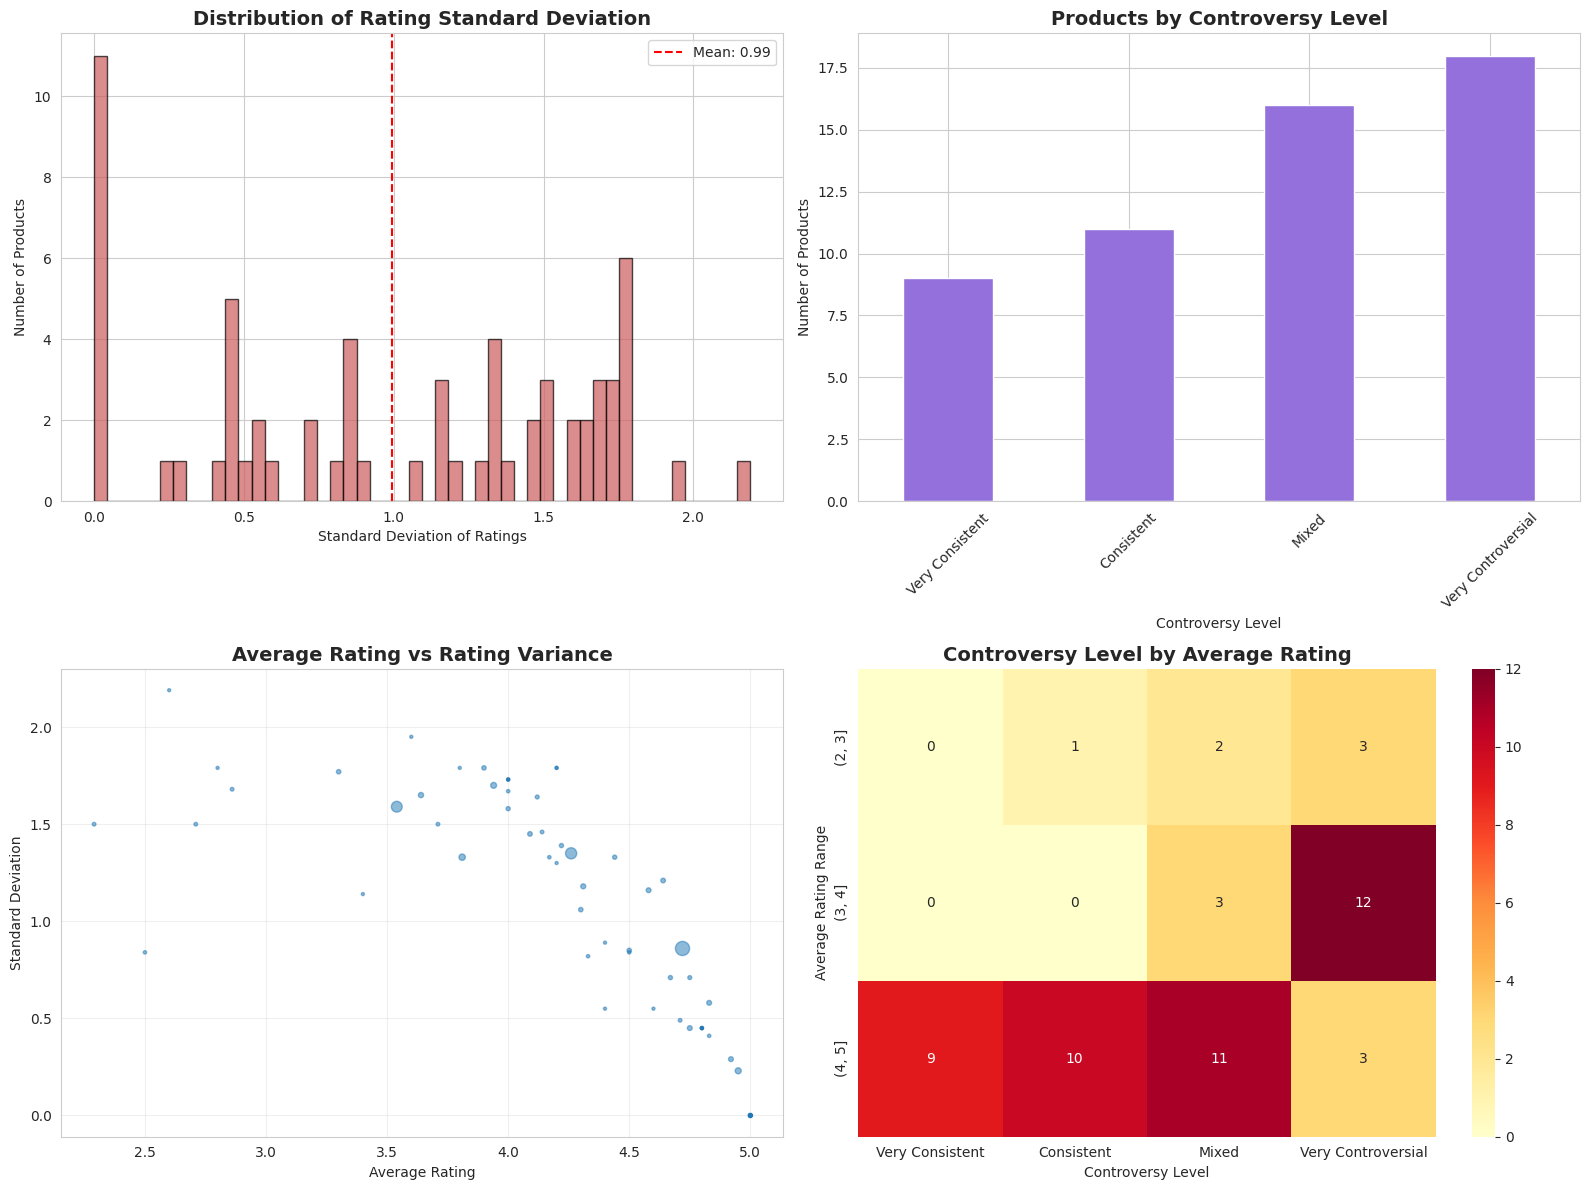

In [ ]:
# RATING VARIANCE BY PRODUCT (CONTROVERSIAL)

print("=" * 60)
print("4. RATING VARIANCE ANALYSIS (CONTROVERSIAL PRODUCTS)")
print("=" * 60)

# Focus on products with enough reviews to have meaningful variance
min_reviews_for_variance = 5
variance_analysis = product_stats[product_stats['review_count'] >= min_reviews_for_variance].copy()

print(f"\nAnalyzing {len(variance_analysis):,} products with {min_reviews_for_variance}+ reviews")
print("\nRating Standard Deviation Distribution:")
print(variance_analysis['std_rating'].describe())

# Categorize by controversy (high variance = controversial)
variance_analysis['controversy'] = pd.cut(variance_analysis['std_rating'],
                                           bins=[0, 0.5, 1.0, 1.5, 5.0],
                                           labels=['Very Consistent', 'Consistent', 'Mixed', 'Very Controversial'])

print("\nProduct Distribution by Controversy Level:")
print(variance_analysis['controversy'].value_counts().sort_index())

# Most controversial products
print(f"\n--- Top 15 Most Controversial Products (highest rating variance) ---")
most_controversial = variance_analysis.nlargest(15, 'std_rating')[['asin', 'avg_rating', 'std_rating', 'review_count', 'min_rating', 'max_rating']]
for idx, row in most_controversial.iterrows():
    print(f"ASIN: {row['asin']} | Avg: {row['avg_rating']:.2f} | Std: {row['std_rating']:.2f} | Range: {row['min_rating']:.0f}-{row['max_rating']:.0f} | Reviews: {int(row['review_count'])}")

# Most consistent products
print(f"\n--- Top 15 Most Consistent Products (lowest rating variance, min 10 reviews) ---")
consistent_products = variance_analysis[variance_analysis['review_count'] >= 10]
most_consistent = consistent_products.nsmallest(15, 'std_rating')[['asin', 'avg_rating', 'std_rating', 'review_count']]
for idx, row in most_consistent.iterrows():
    print(f"ASIN: {row['asin']} | Avg: {row['avg_rating']:.2f} | Std: {row['std_rating']:.2f} | Reviews: {int(row['review_count'])}")

# Correlation analysis
correlation = variance_analysis[['avg_rating', 'std_rating', 'review_count']].corr()
print("\nCorrelation Matrix:")
print(correlation)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Histogram of standard deviation
axes[0, 0].hist(variance_analysis['std_rating'], bins=50, edgecolor='black', alpha=0.7, color='indianred')
axes[0, 0].set_title('Distribution of Rating Standard Deviation', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Standard Deviation of Ratings')
axes[0, 0].set_ylabel('Number of Products')
axes[0, 0].axvline(variance_analysis['std_rating'].mean(), color='red', linestyle='--',
                    label=f'Mean: {variance_analysis["std_rating"].mean():.2f}')
axes[0, 0].legend()

# Controversy categories
variance_analysis['controversy'].value_counts().sort_index().plot(kind='bar', ax=axes[0, 1], color='mediumpurple')
axes[0, 1].set_title('Products by Controversy Level', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Controversy Level')
axes[0, 1].set_ylabel('Number of Products')
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=45)

# Scatter: Avg rating vs Std rating
axes[1, 0].scatter(variance_analysis['avg_rating'], variance_analysis['std_rating'],
                   alpha=0.5, s=variance_analysis['review_count'])
axes[1, 0].set_title('Average Rating vs Rating Variance', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Average Rating')
axes[1, 0].set_ylabel('Standard Deviation')
axes[1, 0].grid(True, alpha=0.3)

# Heatmap of controversy by avg rating
controversy_by_rating = pd.crosstab(
    pd.cut(variance_analysis['avg_rating'], bins=[0, 2, 3, 4, 5]),
    variance_analysis['controversy']
)
sns.heatmap(controversy_by_rating, annot=True, fmt='d', cmap='YlOrRd', ax=axes[1, 1])
axes[1, 1].set_title('Controversy Level by Average Rating', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Controversy Level')
axes[1, 1].set_ylabel('Average Rating Range')

plt.tight_layout()
plt.show()